In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2025 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
#
###############################################################################

# Autothermal Reformer Flowsheet Optimization with PySMO Surrogate Object
Maintainer: Brandon Paul  
Author: Brandon Paul  
Updated: 2023-06-01  
## 1. Introduction

This example demonstrates autothermal reformer optimization leveraging the PySMO Polynomial surrogate trainer. Other than the specific training method syntax, this workflow is identical for PySMO RBF and PySMO Kriging surrogate models. In this notebook, sampled simulation data will be used to train and validate a surrogate model. IDAES surrogate plotting tools will be utilized to visualize the surrogates on training and validation data. Once validated, integration of the surrogate into an IDAES flowsheet will be demonstrated.

# 2. Problem Statement 

Within the context of a larger NGFC system, the autothermal reformer generates syngas from air, steam and natural gas for use in a solid-oxide fuel cell (SOFC).

## 2.1. Main Inputs: 
- Bypass fraction (dimensionless) - split fraction of natural gas to bypass AR unit and feed directly to the power island
- NG-Steam Ratio (dimensionless) - proportion of natural relative to steam fed into AR unit operation

## 2.2. Main Outputs:
- Steam flowrate (kg/s) - inlet steam fed to AR unit
- Reformer duty (kW) - required energy input to AR unit
- Composition (dimensionless) - outlet mole fractions of components (Ar, C2H6, C3H8, C4H10, CH4, CO, CO2, H2, H2O, N2, O2)

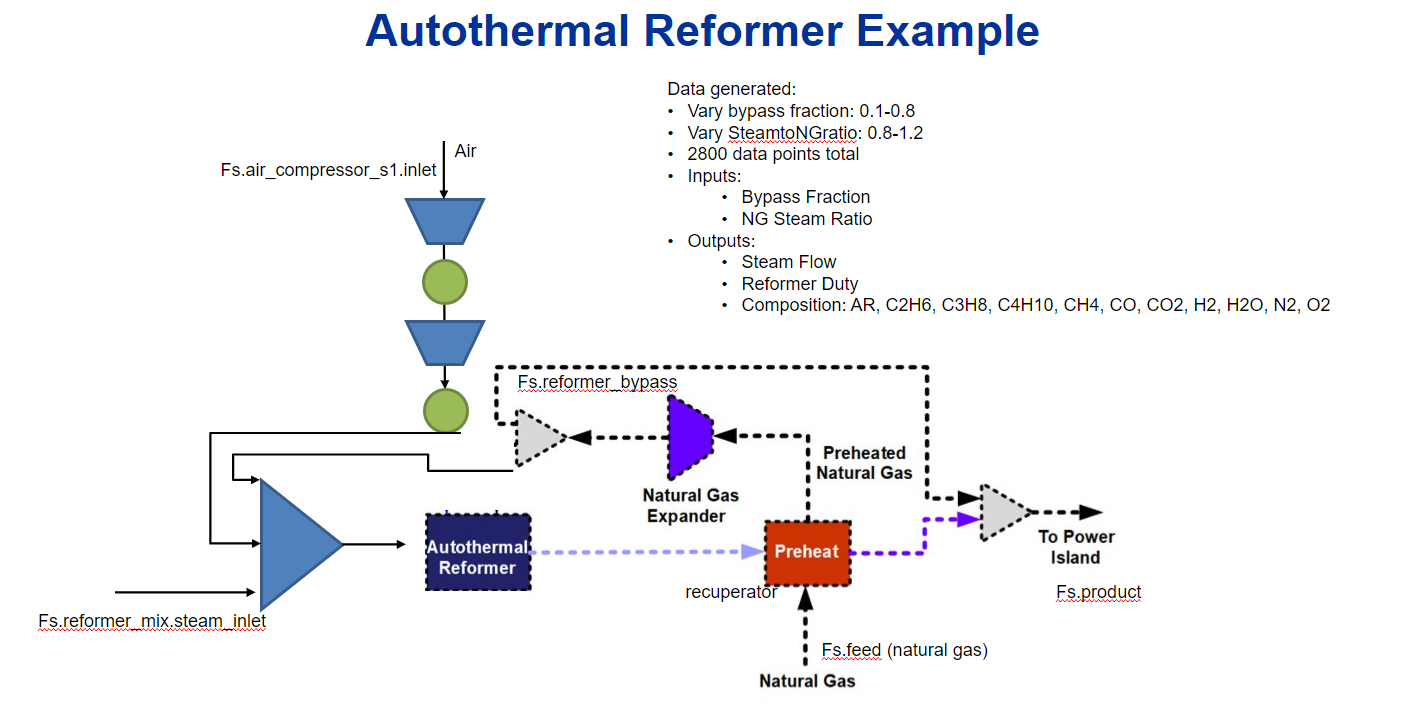

In [2]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("AR_PFD.png"))

## 3. Training and Validating Surrogates

First, let's import the required Python, Pyomo and IDAES modules:

In [3]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import Pyomo libraries
from pyomo.environ import (
    ConcreteModel,
    SolverFactory,
    value,
    Var,
    Constraint,
    Set,
    Objective,
    maximize,
)
from pyomo.common.timing import TicTocTimer

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.pysmo_surrogate import PysmoPolyTrainer, PysmoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock

## 3.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 2800 data points were simulated from a rigorous IDAES NGFC flowsheet using a grid sampling method. For simplicity and to reduce training runtime, this example randomly selects 100 data points to use for training/validation. The data is separated using an 80/20 split into training and validation data using the IDAES `split_training_validation()` method.

In [4]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(datafile_path("reformer-data.csv"))  # 2800 data points
data = csv_data.sample(n=100)  # randomly sample points for training/validation
input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:]

# Define labels, and split training and validation data
# note that PySMO requires that labels are passed as string lists
input_labels = list(input_data.columns)
output_labels = list(output_data.columns)

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)  # seed=100

/home/dang/miniforge3/envs/idaes_examples_py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## 3.2 Training Surrogates with PySMO

IDAES builds a model class for each type of PySMO surrogate model. In this case, we will call and build the Polynomial Regression class. Regression settings can be directly passed as class arguments, as shown below. In this example, allowed basis terms span a 6th order polynomial as well as a variable product, and data is internally cross-validated using 10 iterations of 80/20 splits to ensure a robust surrogate fit. Note that PySMO uses cross-validation of training data to adjust model coefficients and ensure a more accurate fit, while we separate the validation dataset pre-training in order to visualize the surrogate fits.

Finally, after training the model we save the results and model expressions to a folder which contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [5]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create PySMO trainer object
trainer = PysmoPolyTrainer(
    input_labels=input_labels,
    output_labels=output_labels,
    training_dataframe=data_training,
)

# Set PySMO options
trainer.config.maximum_polynomial_order = 6
trainer.config.multinomials = True
trainer.config.training_split = 0.8
trainer.config.number_of_crossvalidations = 10

# Train surrogate (calls PySMO through IDAES Python wrapper)
poly_train = trainer.train_surrogate()

# create callable surrogate object
xmin, xmax = [0.1, 0.8], [0.8, 1.2]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}
poly_surr = PysmoSurrogate(poly_train, input_labels, output_labels, input_bounds)

# save model to JSON
model = poly_surr.save_to_file("pysmo_poly_surrogate.json", overwrite=True)

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)

2025-03-17 17:37:56 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Steam_Flow trained successfully


2025-03-17 17:37:57 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output Reformer_Duty trained successfully


2025-03-17 17:37:58 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output AR trained successfully


2025-03-17 17:37:59 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C2H6 trained successfully


2025-03-17 17:38:00 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C3H8 trained successfully


2025-03-17 17:38:01 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output C4H10 trained successfully


2025-03-17 17:38:01 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CH4 trained successfully


2025-03-17 17:38:02 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CO trained successfully


2025-03-17 17:38:03 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output CO2 trained successfully


2025-03-17 17:38:04 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output H2 trained successfully


2025-03-17 17:38:05 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output H2O trained successfully


2025-03-17 17:38:06 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output N2 trained successfully


2025-03-17 17:38:07 [WARNING] idaes.core.surrogate.pysmo.polynomial_regression: Polynomial regression generates poor fit for the dataset


2025-03-17 17:38:07 [INFO] idaes.core.surrogate.pysmo_surrogate: Model for output O2 trained successfully



===========================Polynomial Regression===============================================


No iterations will be run.
Default parameter estimation method is used.
Parameter estimation method:  pyomo 

max_fraction_training_samples set at  0.5
Number of adaptive samples (no_adaptive_samples) set at  4
Maximum number of iterations (Max_iter) set at:  0

Initial surrogate model is of order 3  with a cross-val error of 0.000000
Initial Regression Model Performance:
Order:  3  / MAE: 0.000000  / MSE: 0.000000  / R^2: 1.000000  / Adjusted R^2: 1.000000

Polynomial regression generates a good surrogate model for the input data.

-------------------------------------------------
-------------------------------------------------
Best solution found:  
Order:  3  / MAE: 0.000000  / MSE: 0.000000  / R_sq: 1.000000  / Adjusted R^2: 1.000000

------------------------------------------------------------
The final coefficients of the regression terms are: 

k               | -0.0
(x_ 1 )^ 1  

## 3.3 Visualizing surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

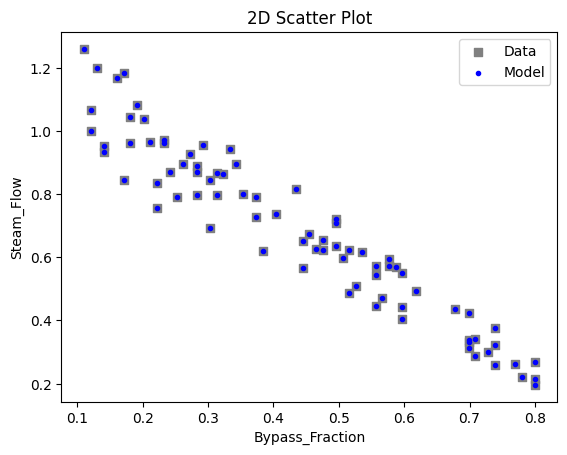

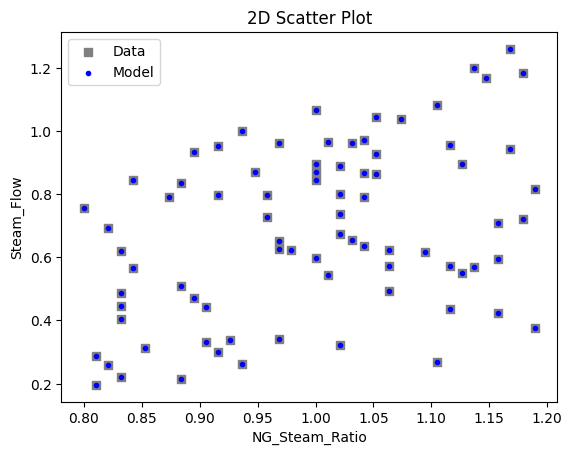

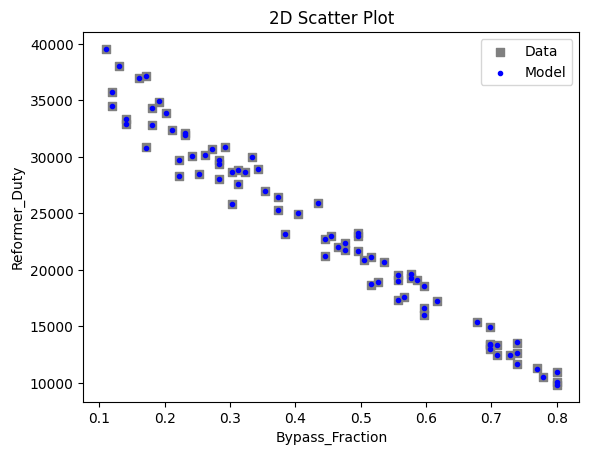

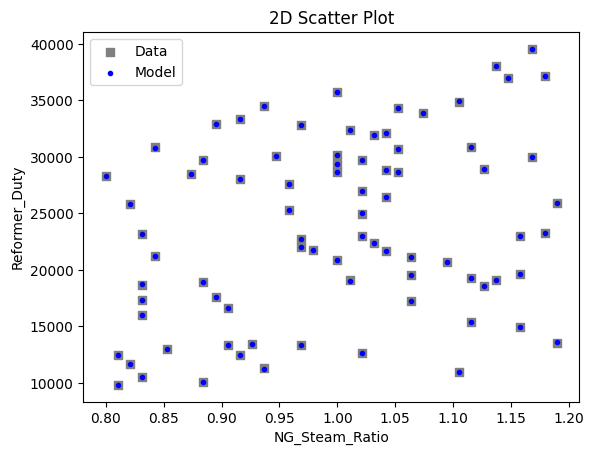

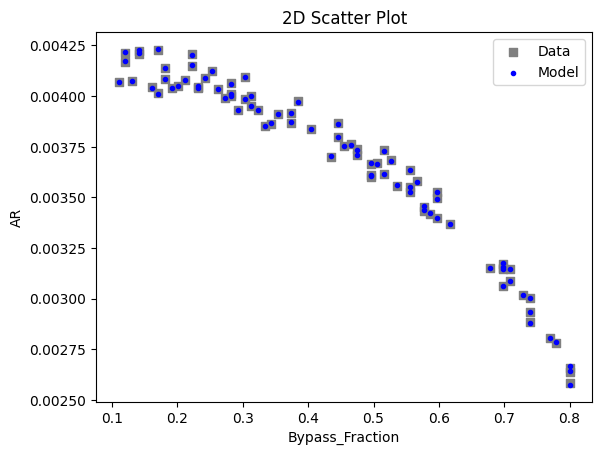

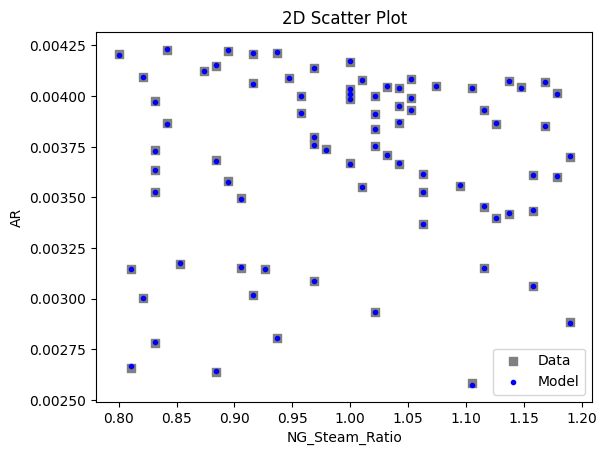

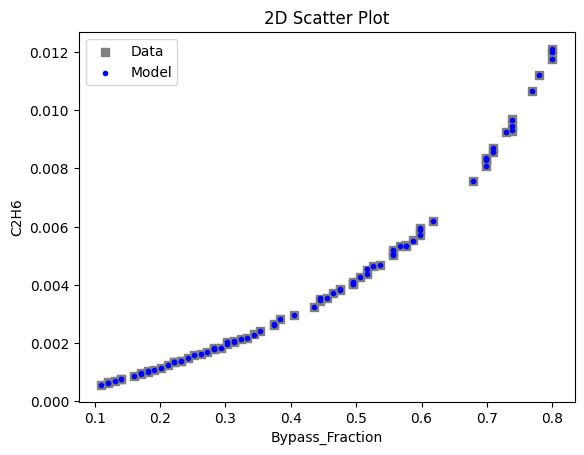

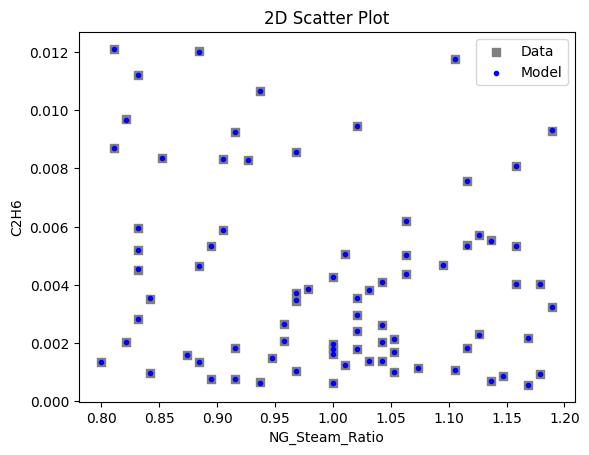

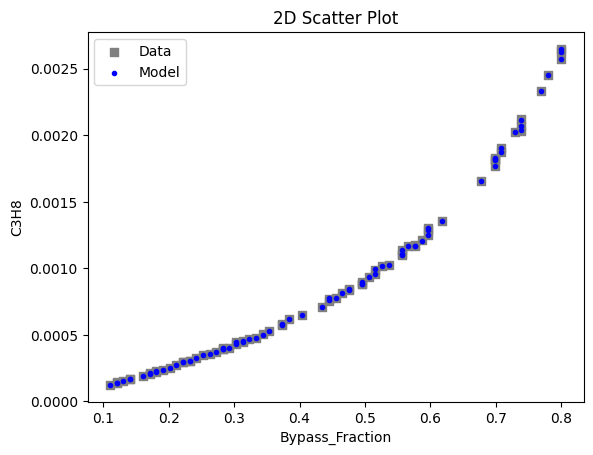

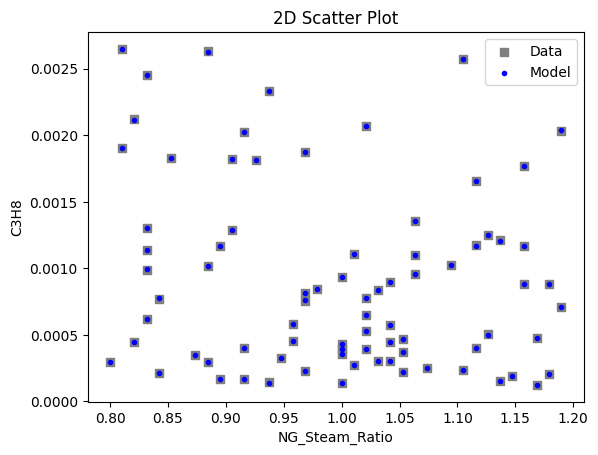

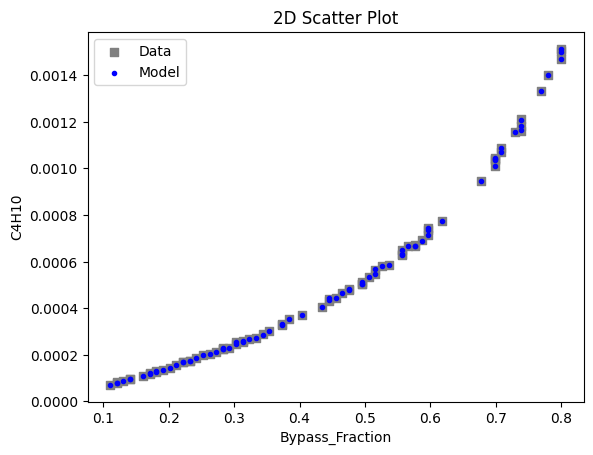

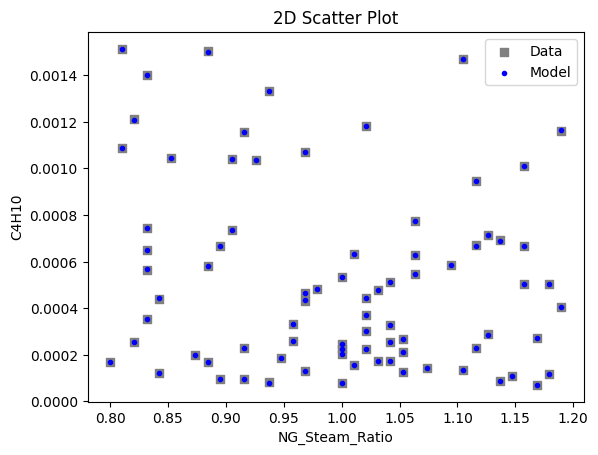

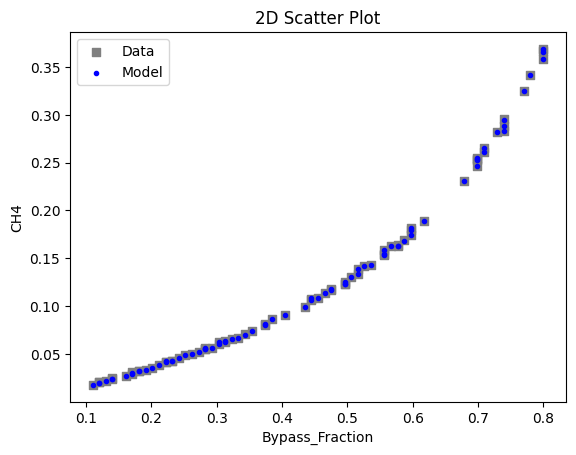

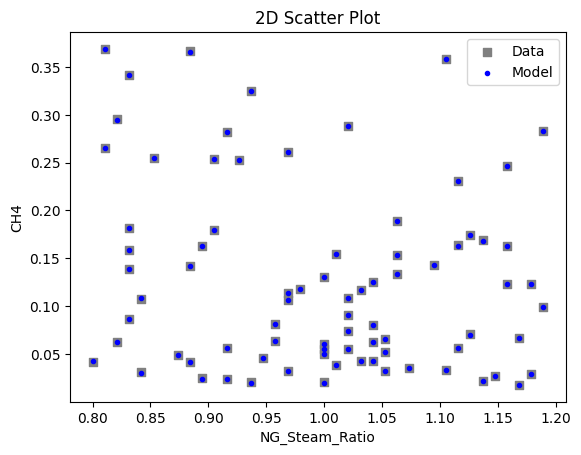

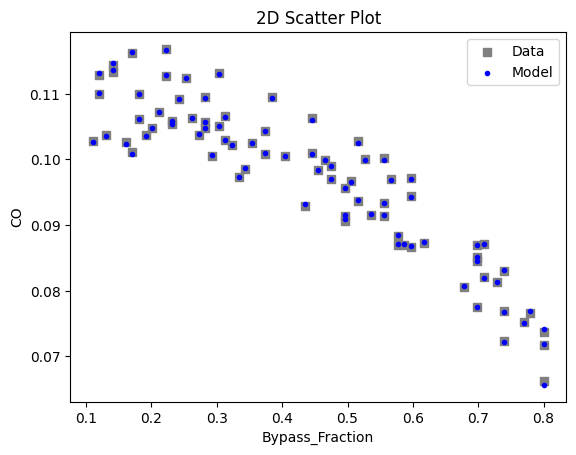

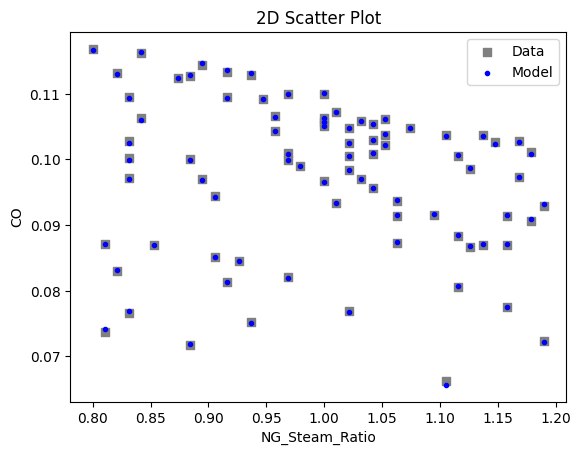

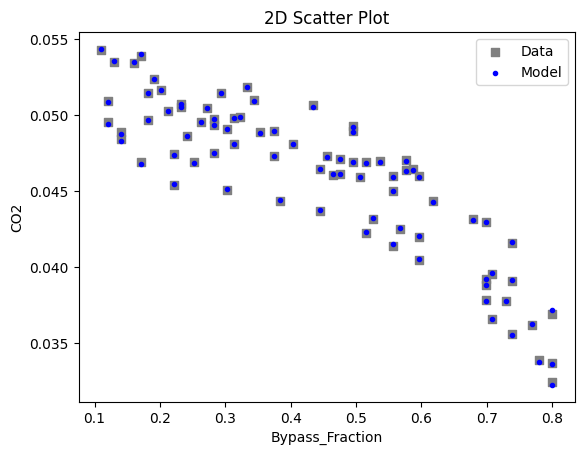

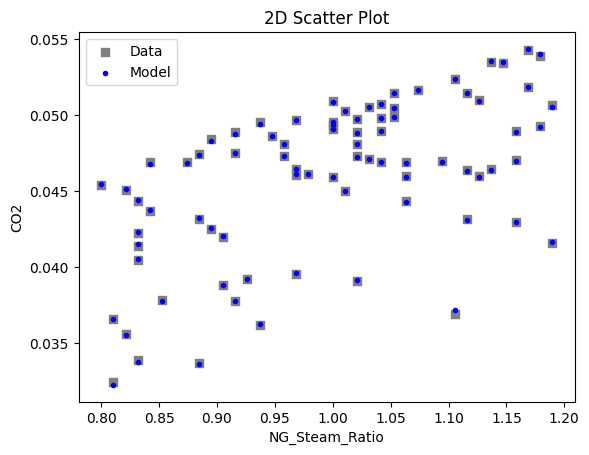

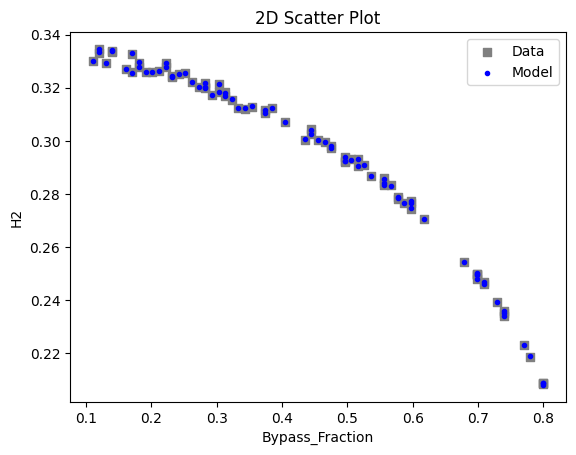

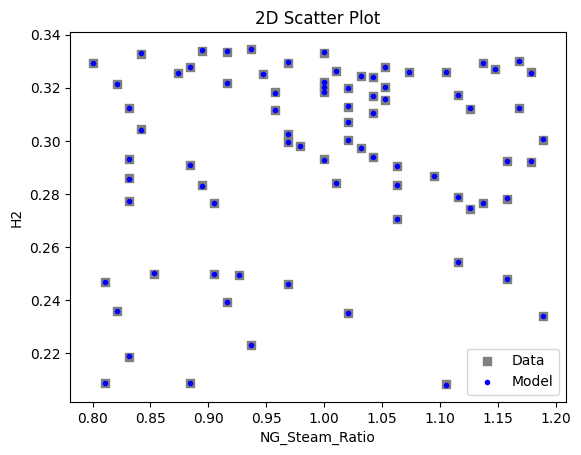

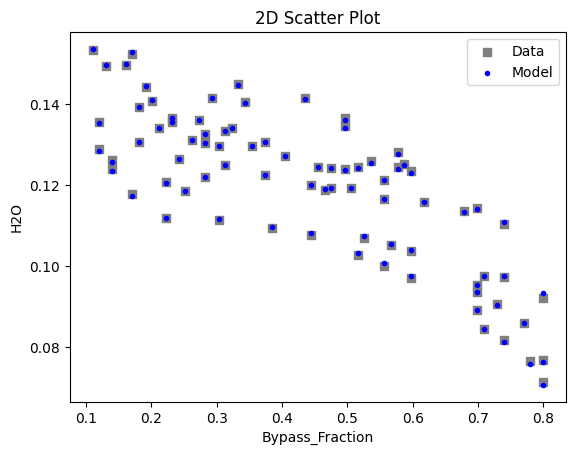

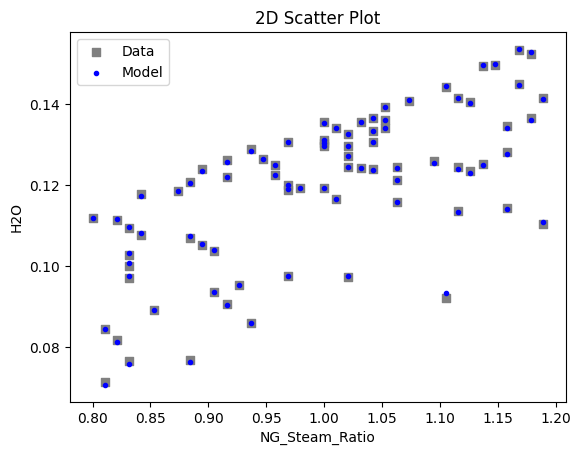

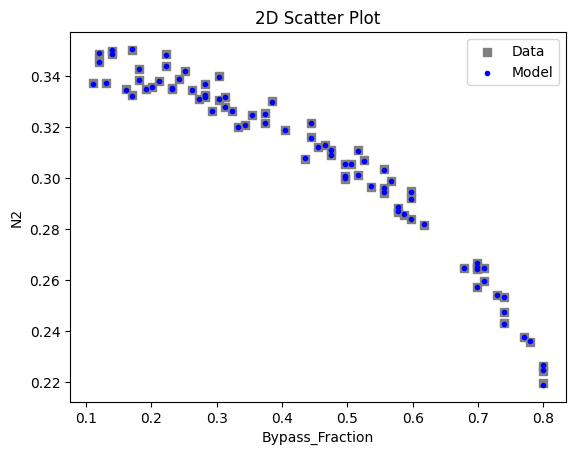

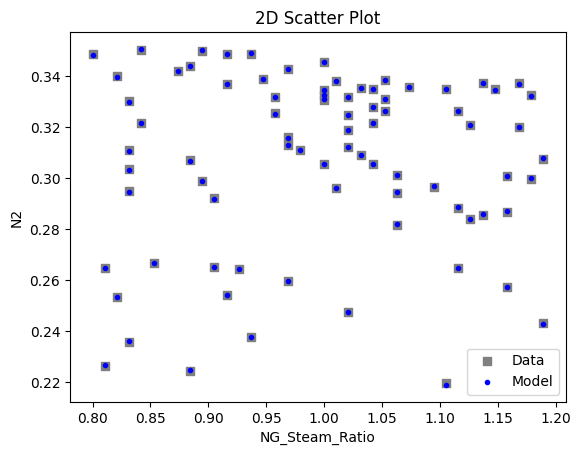

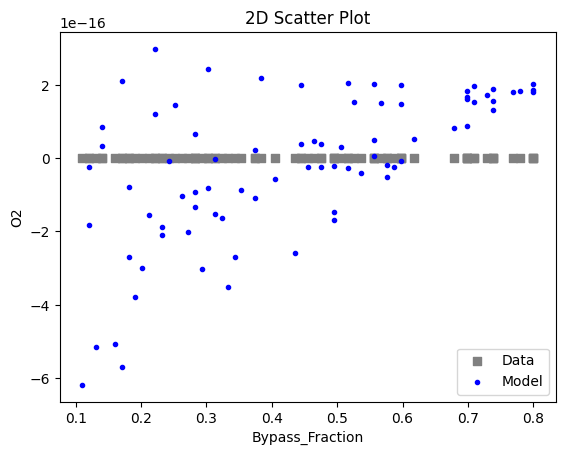

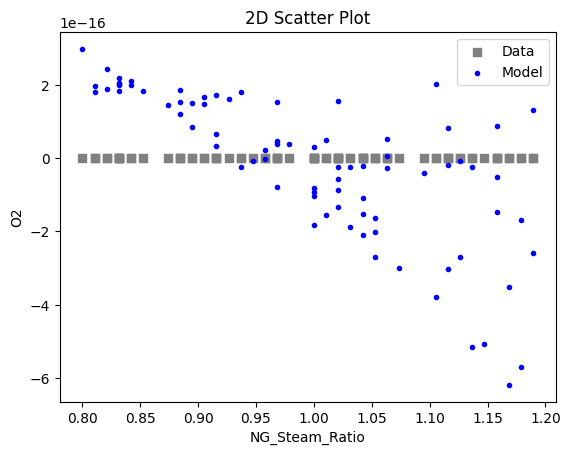

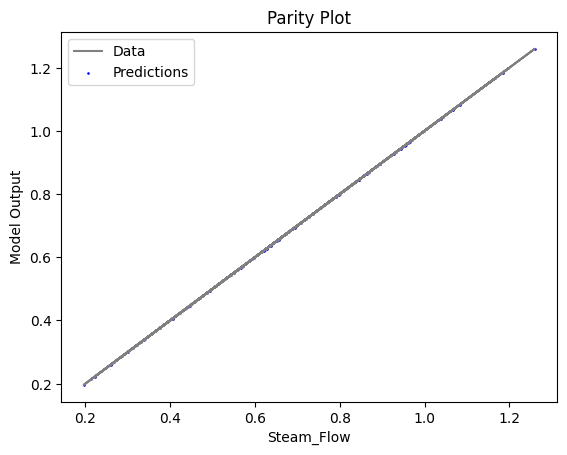

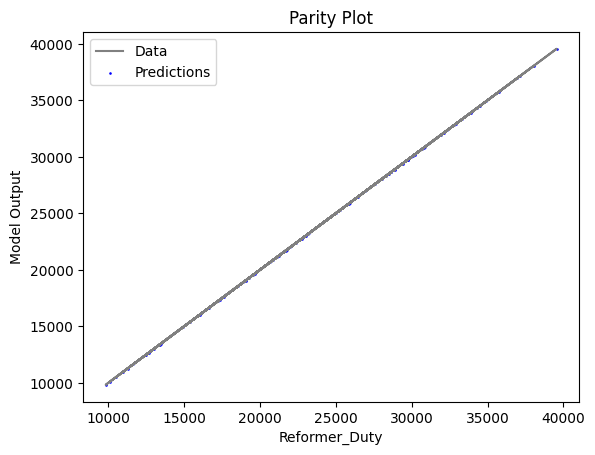

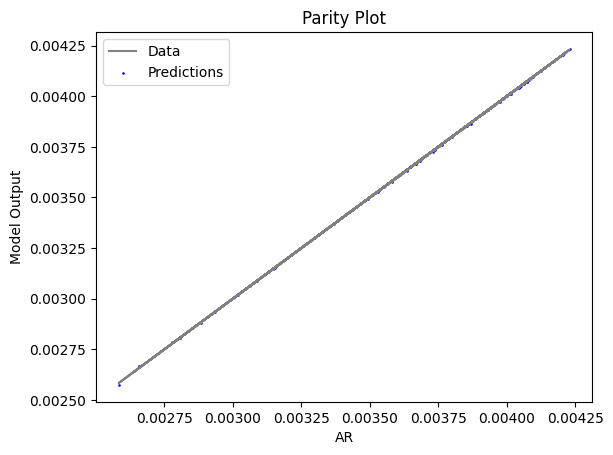

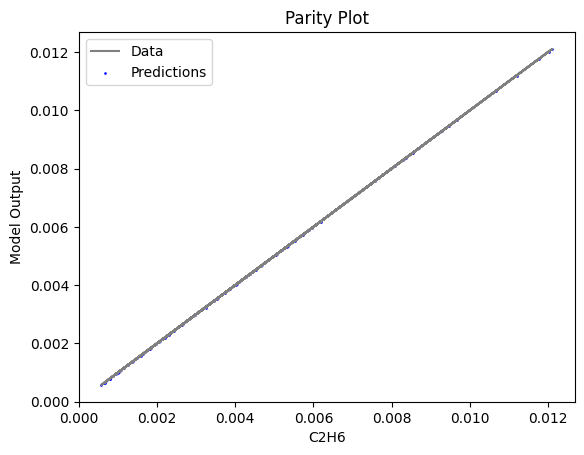

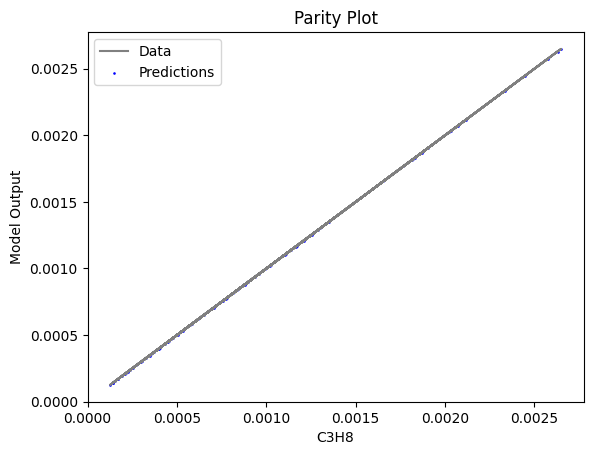

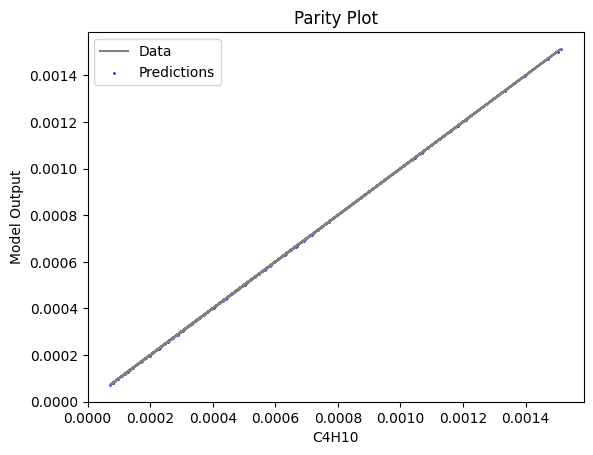

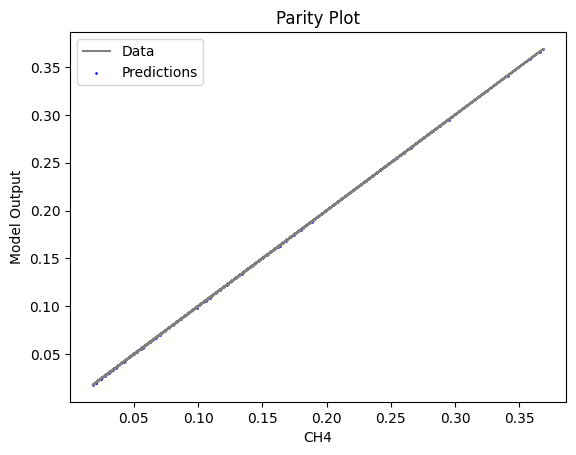

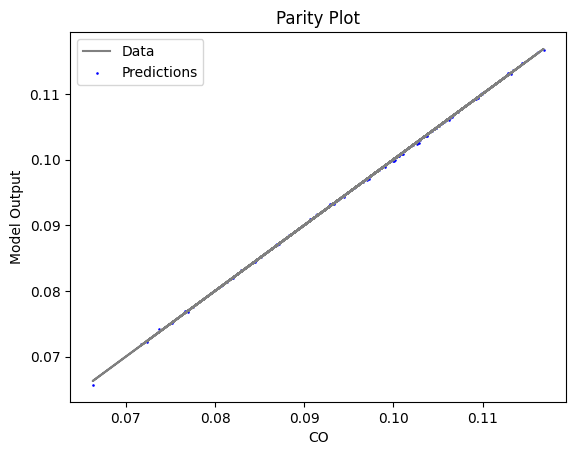

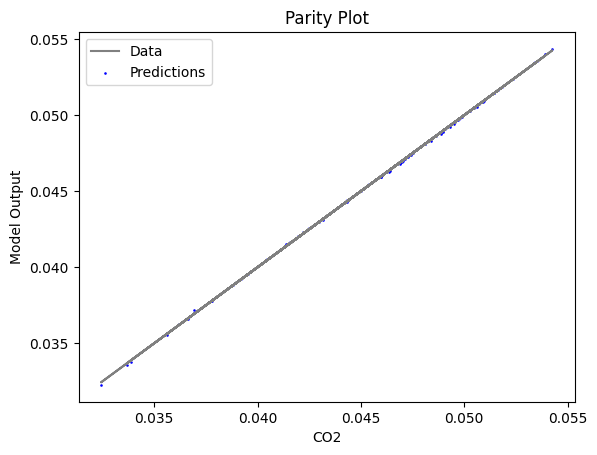

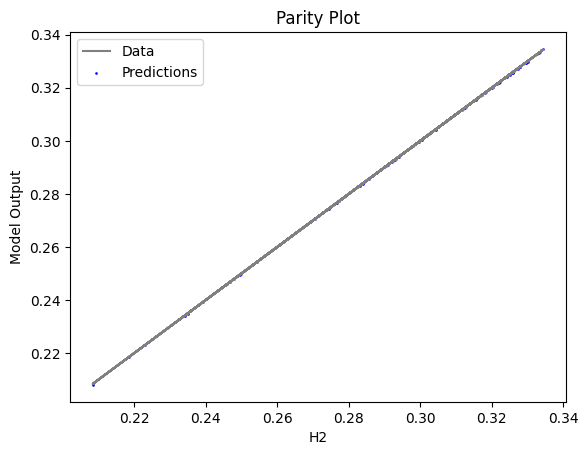

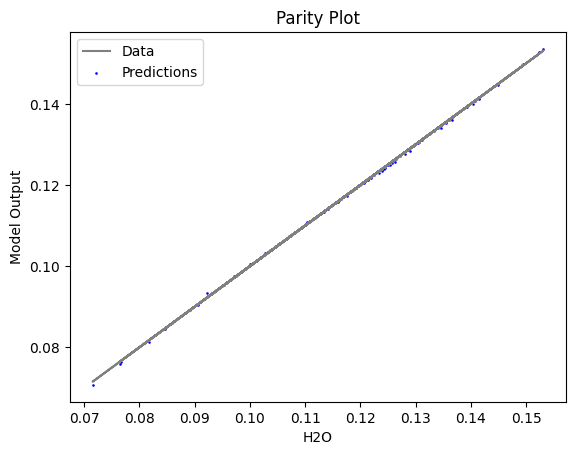

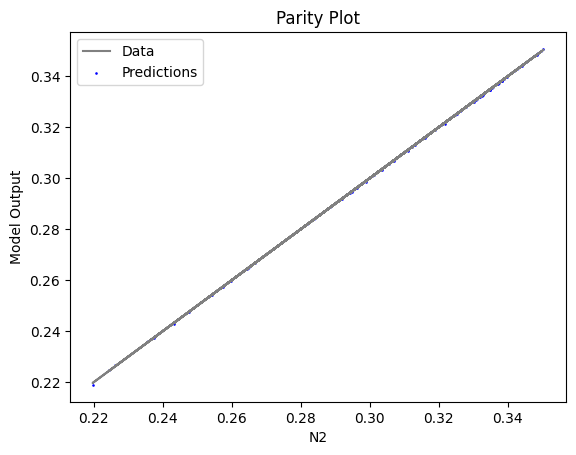

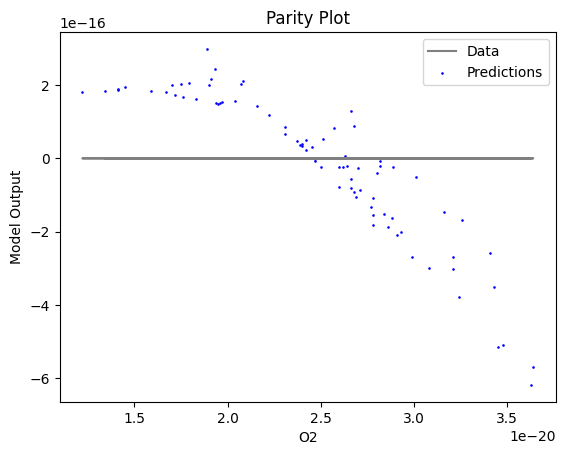

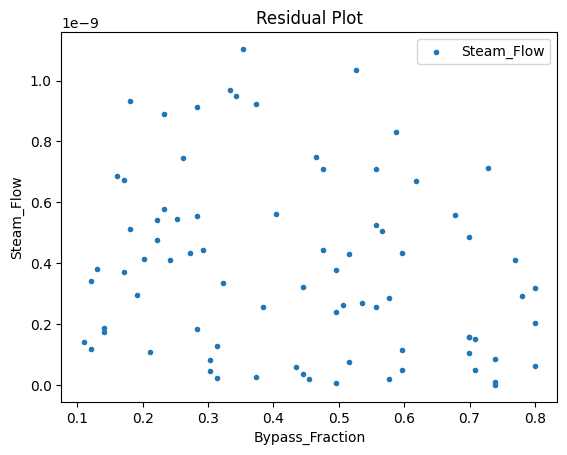

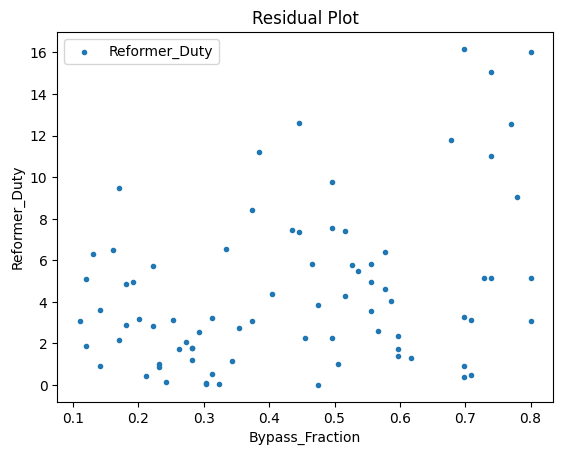

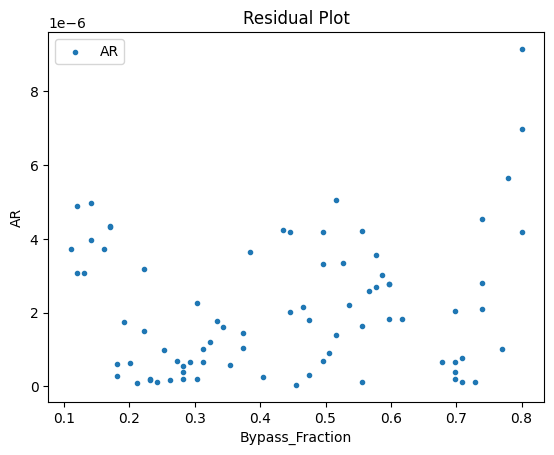

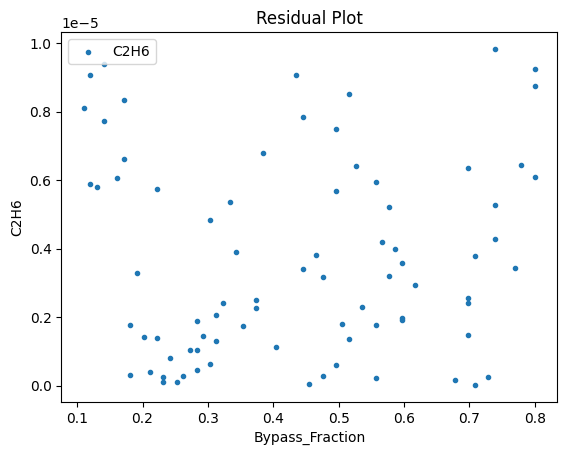

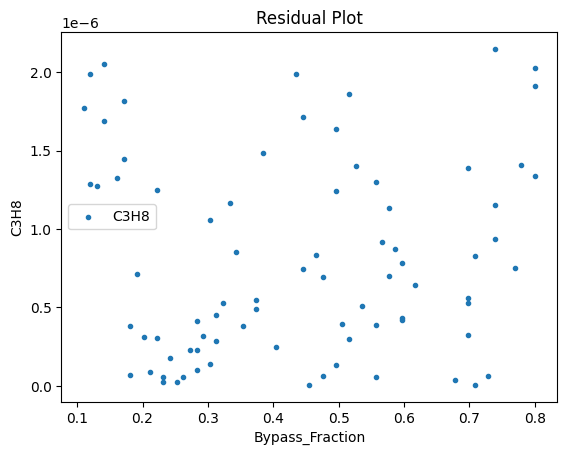

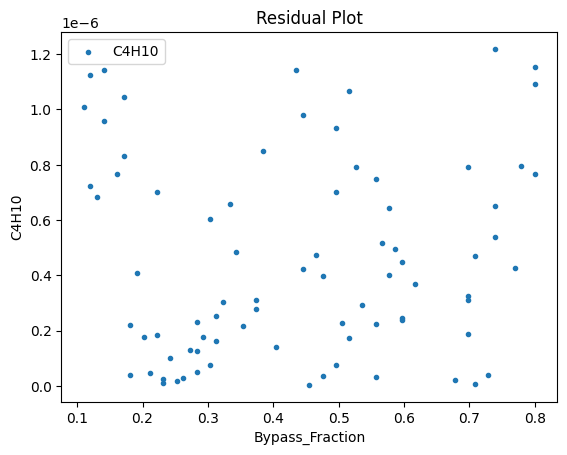

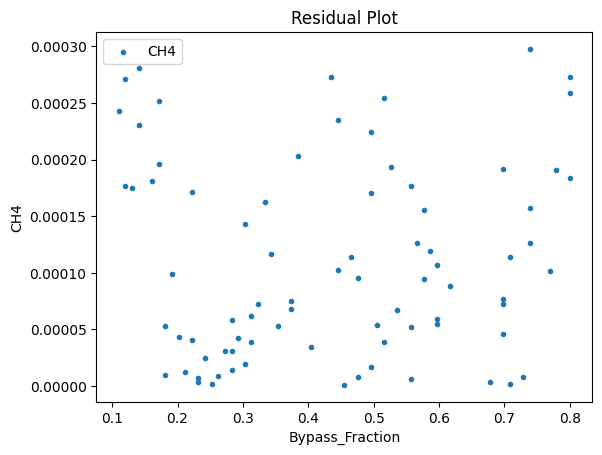

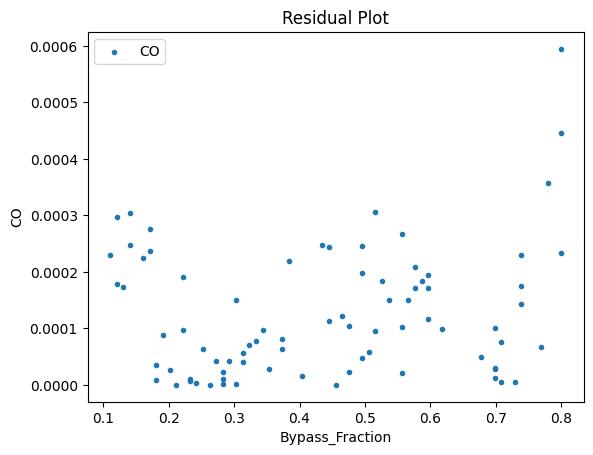

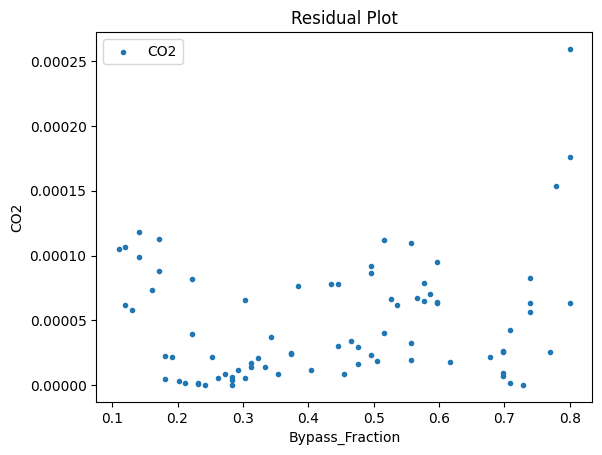

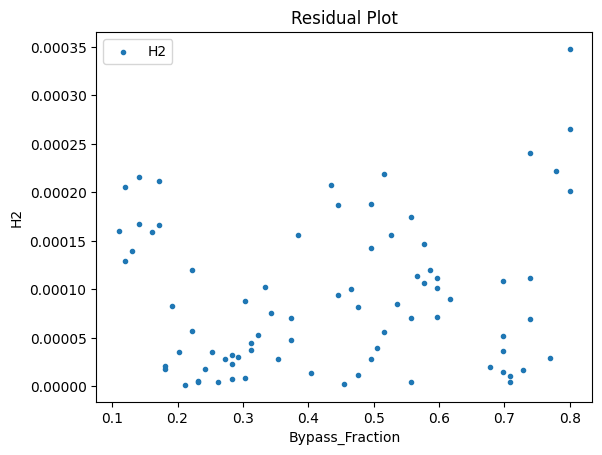

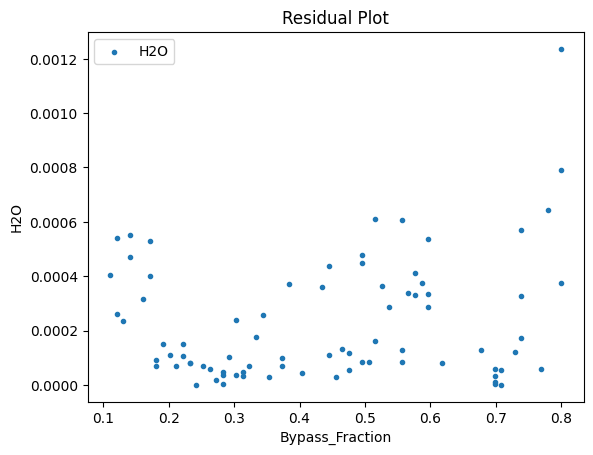

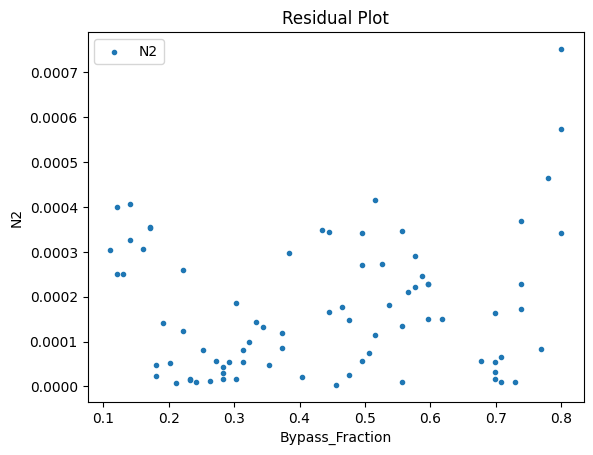

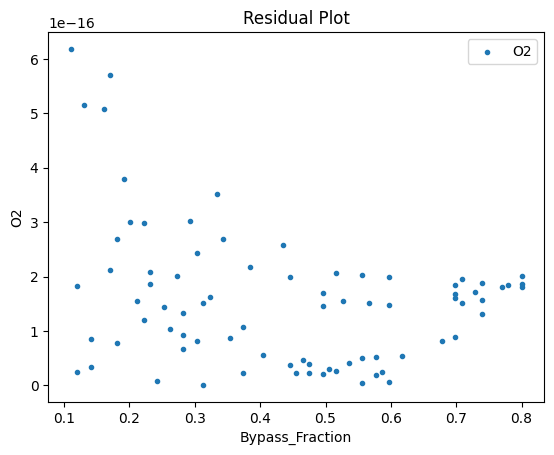

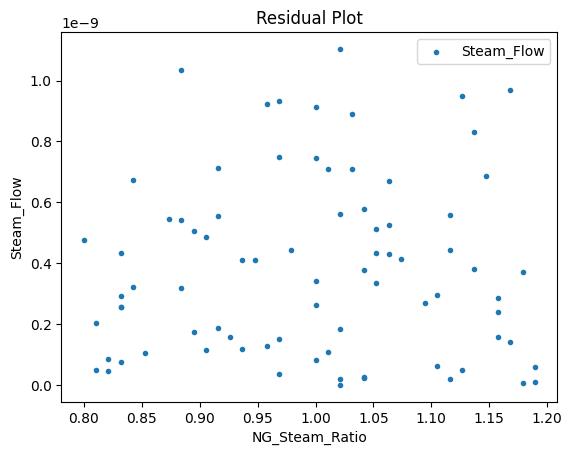

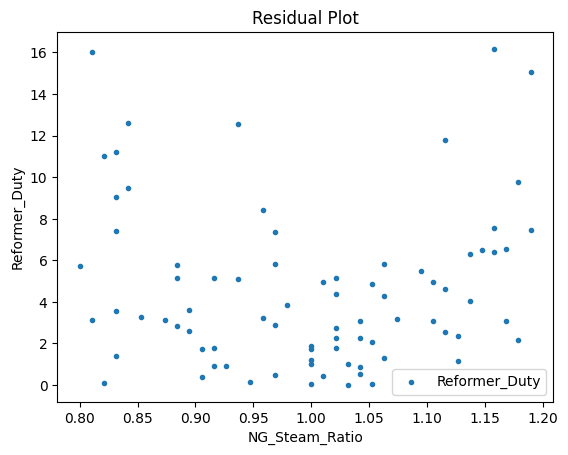

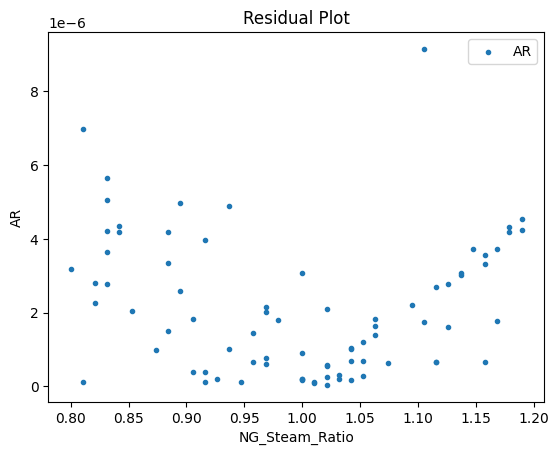

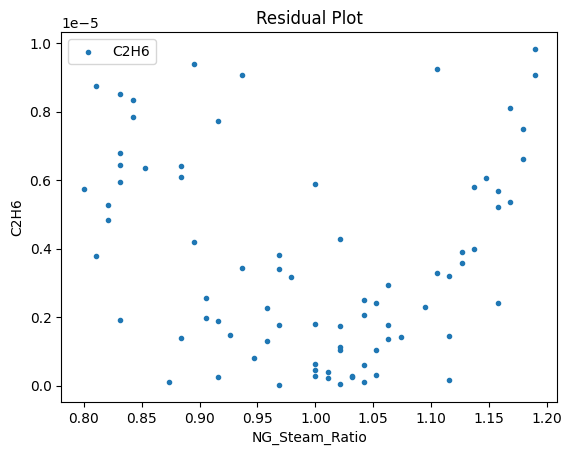

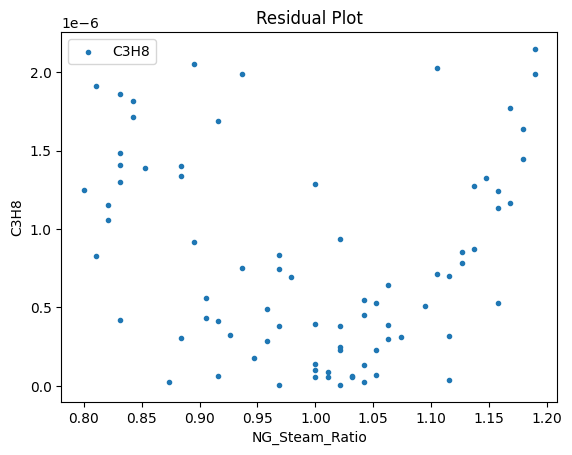

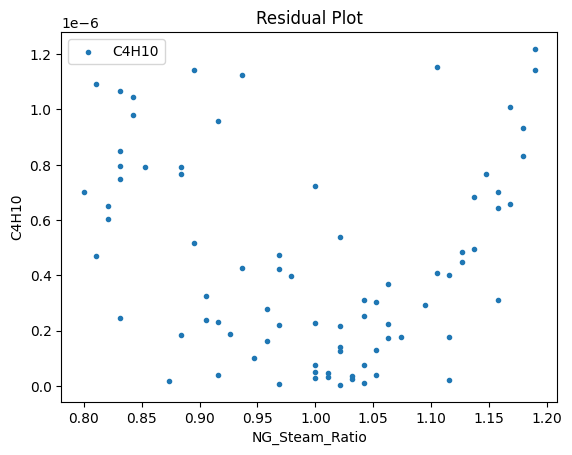

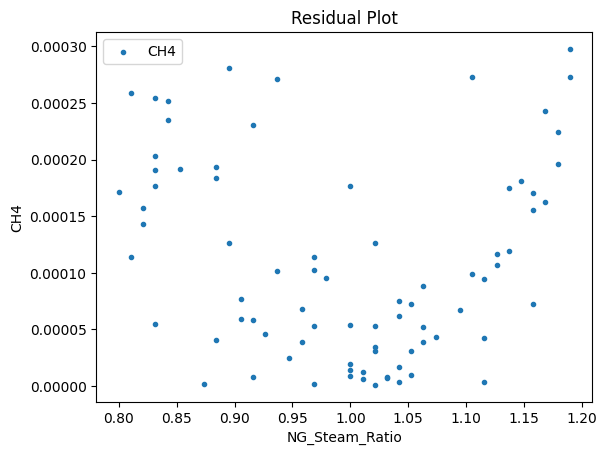

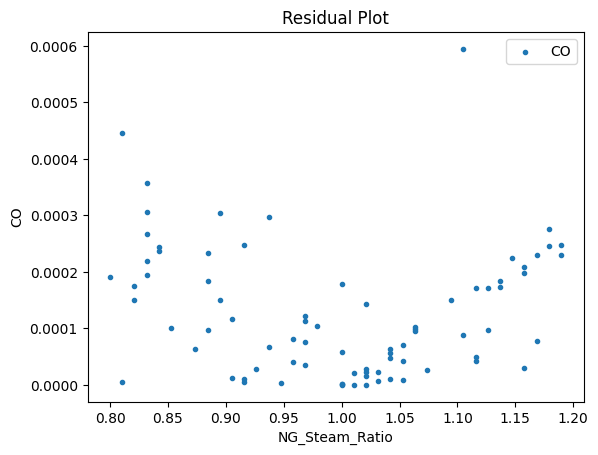

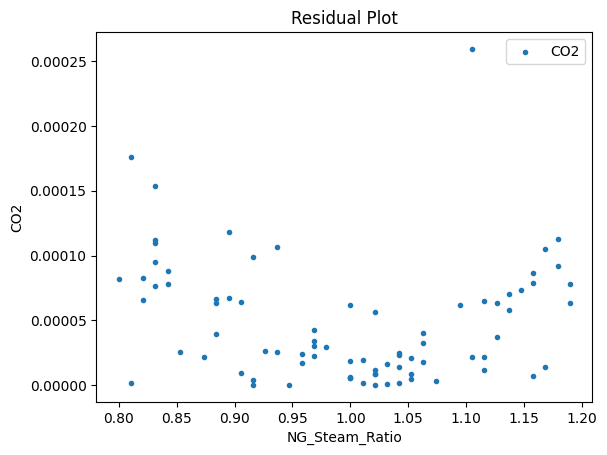

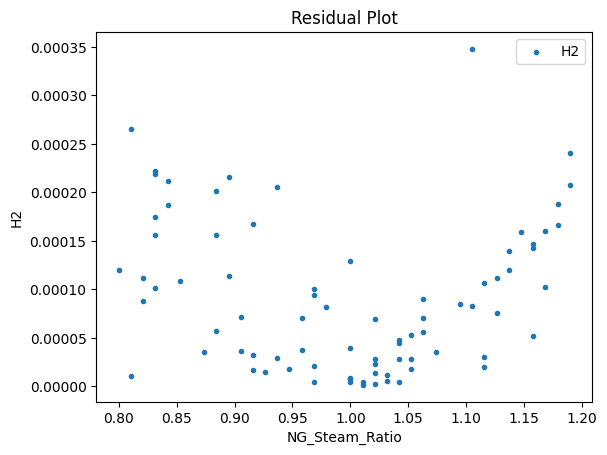

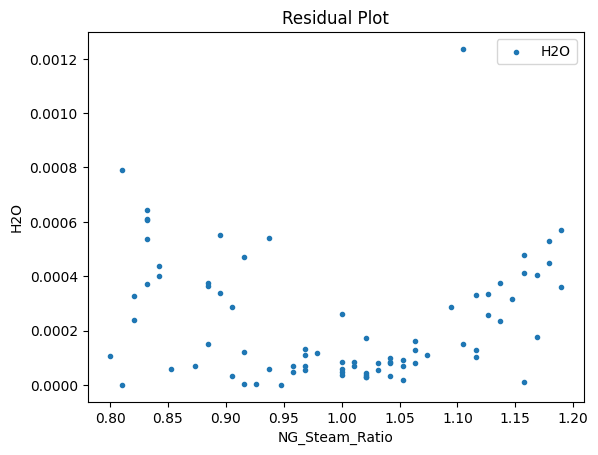

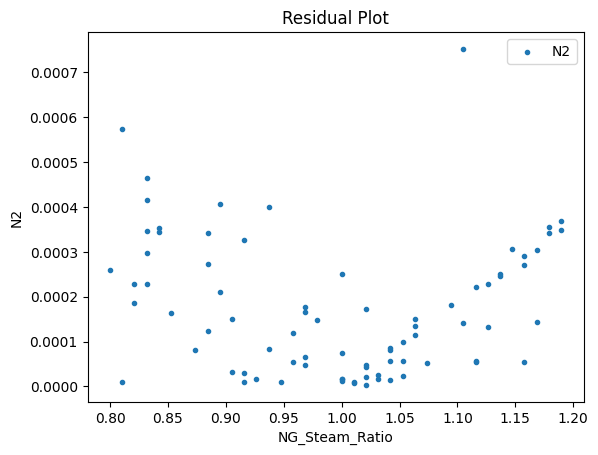

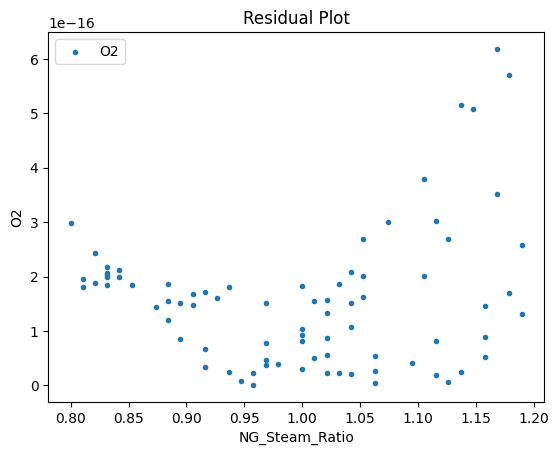

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_training, filename="pysmo_poly_train_scatter2D.pdf")
surrogate_parity(poly_surr, data_training, filename="pysmo_poly_train_parity.pdf")
surrogate_residual(poly_surr, data_training, filename="pysmo_poly_train_residual.pdf")

## 3.4 Model Validation

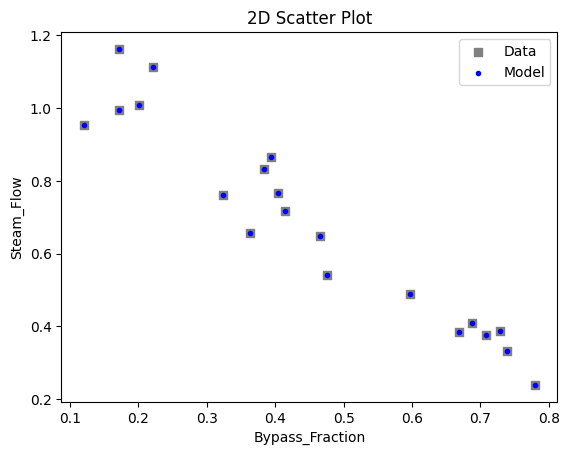

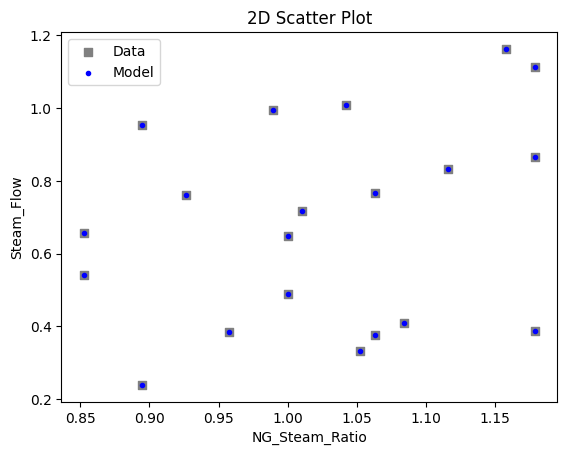

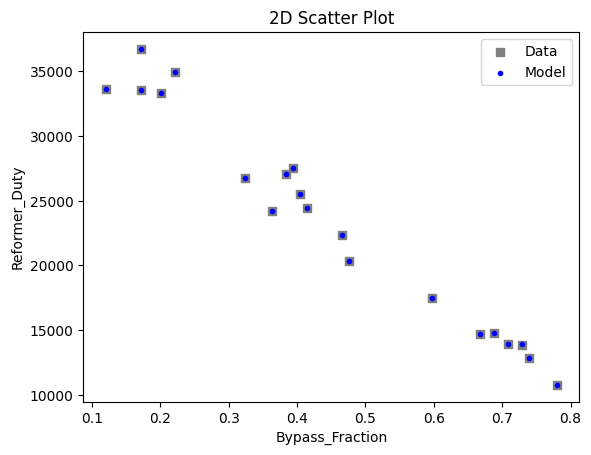

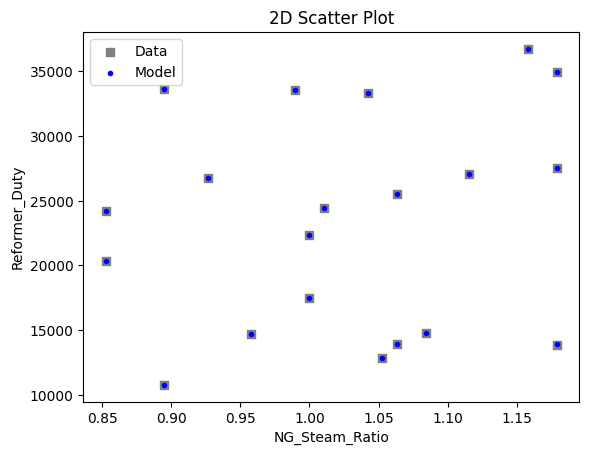

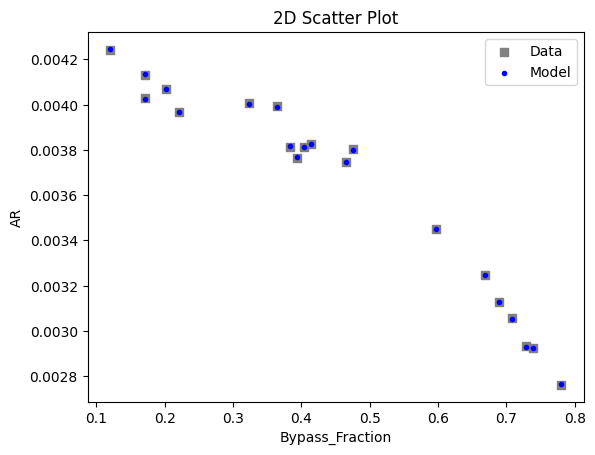

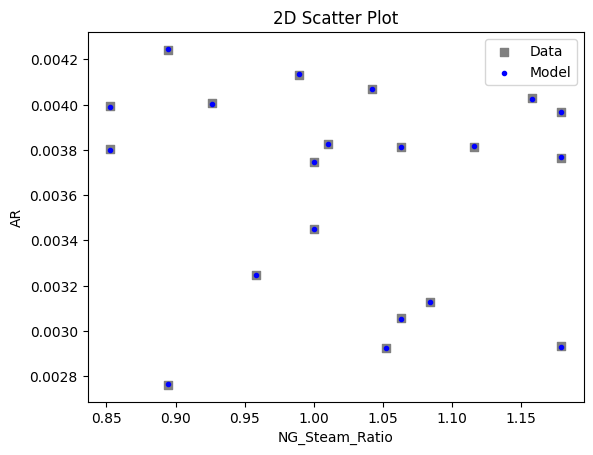

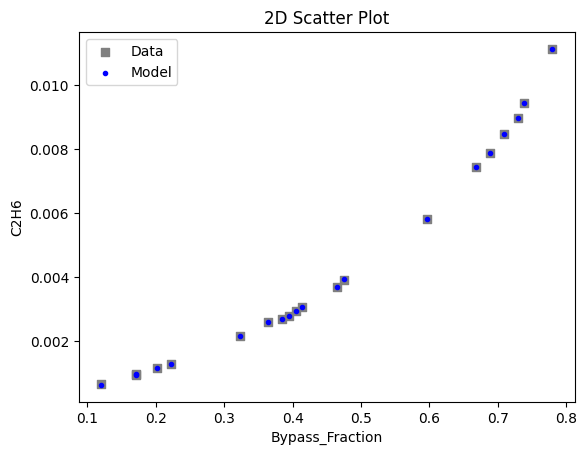

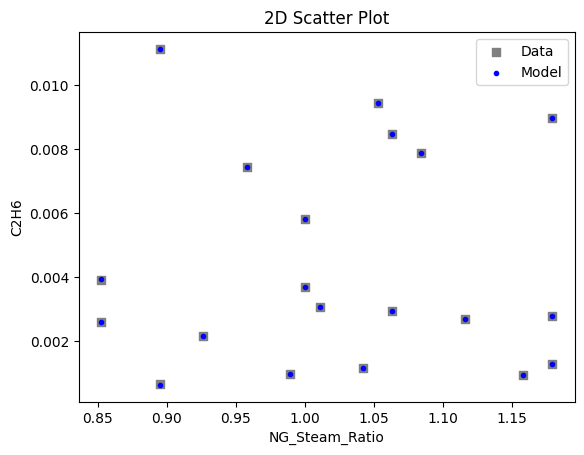

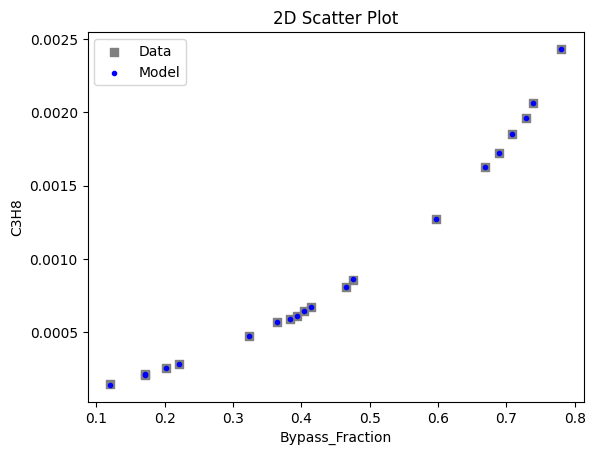

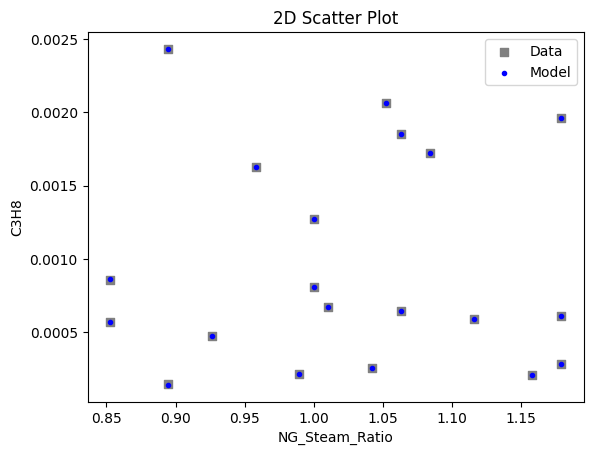

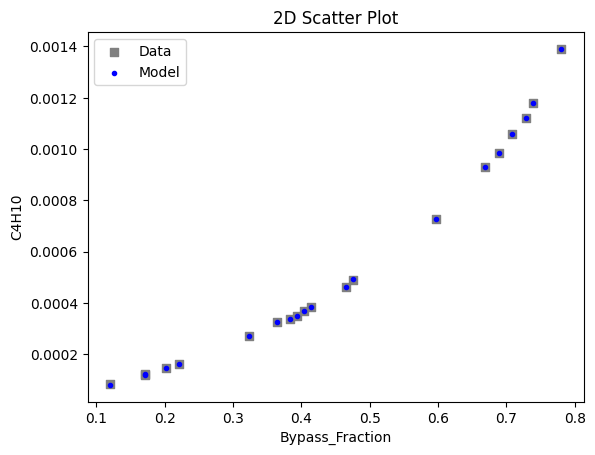

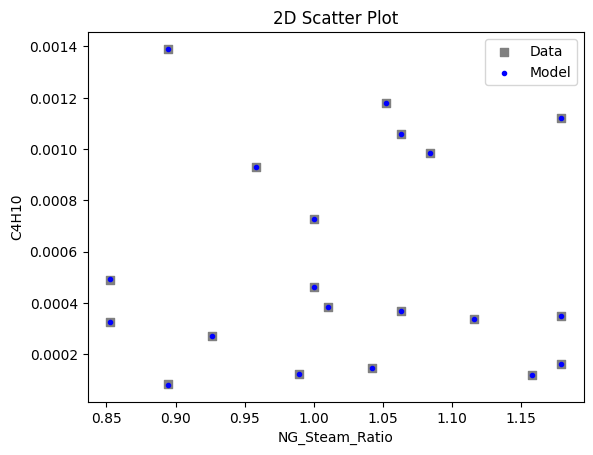

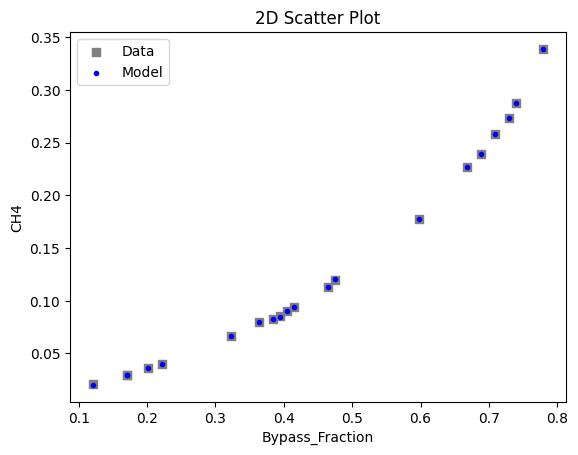

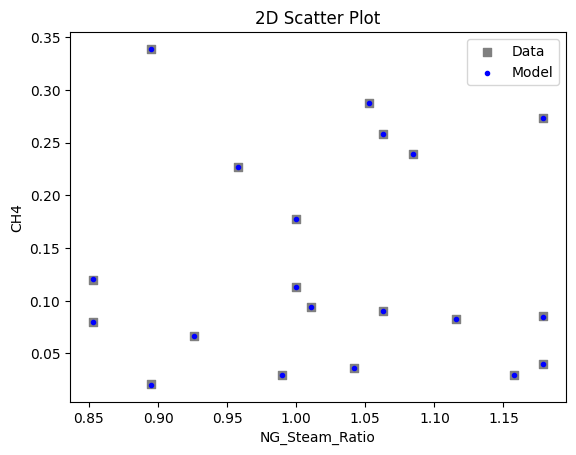

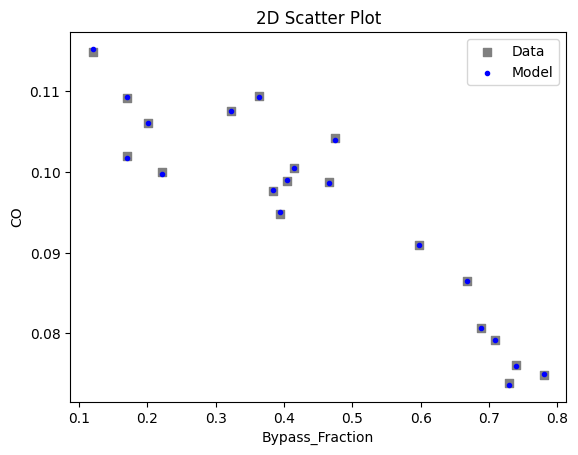

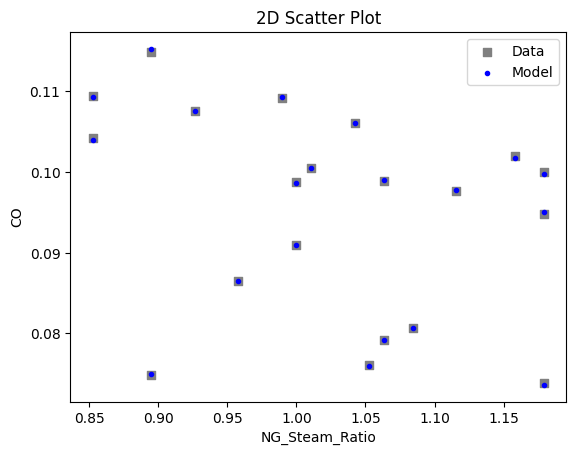

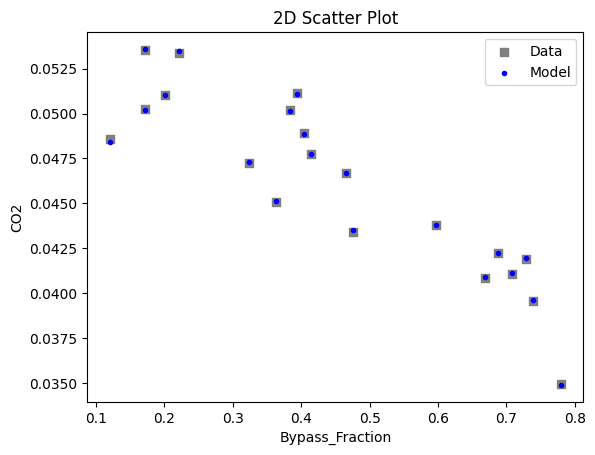

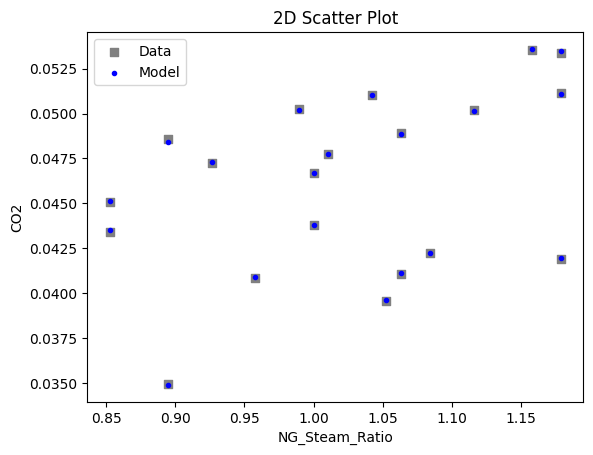

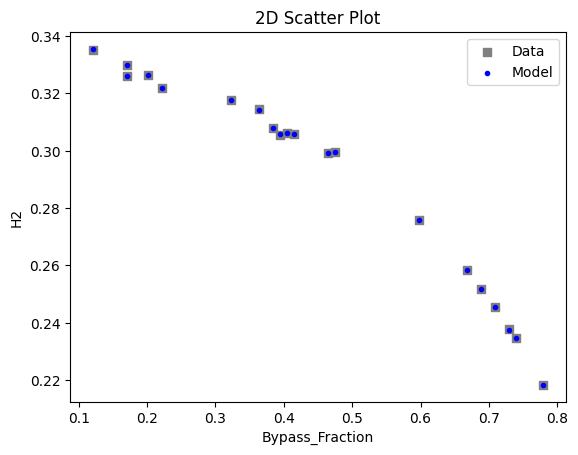

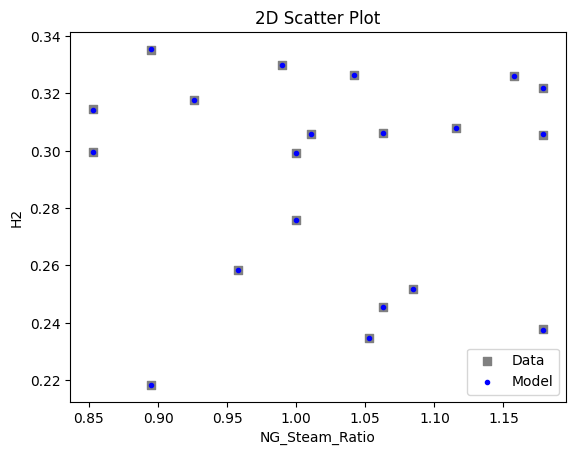

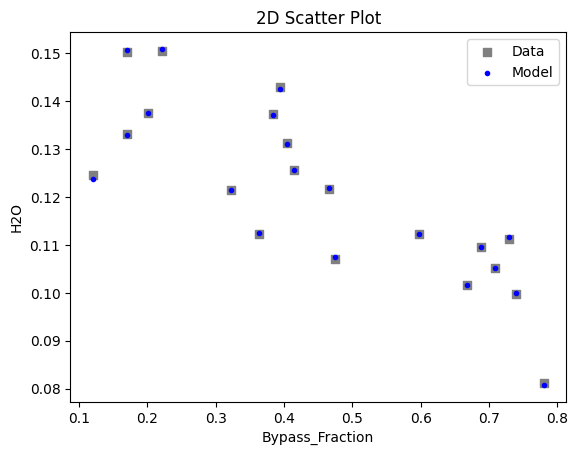

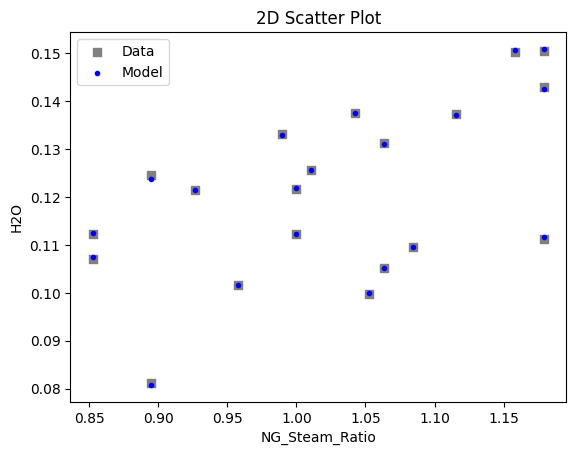

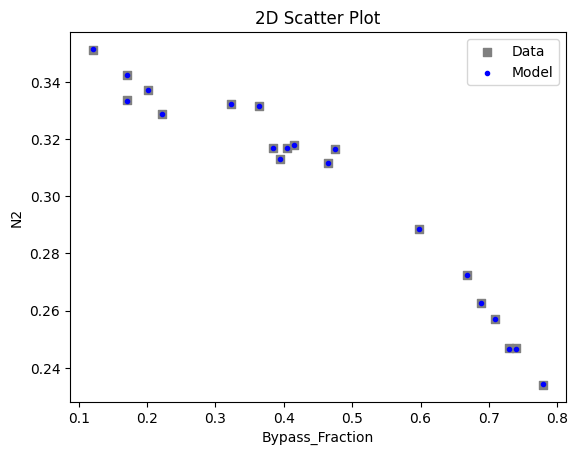

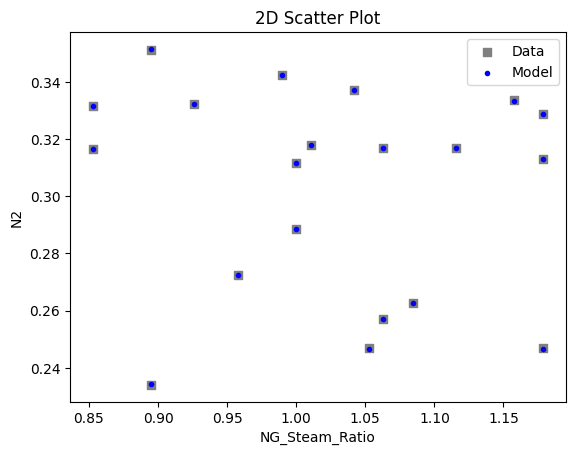

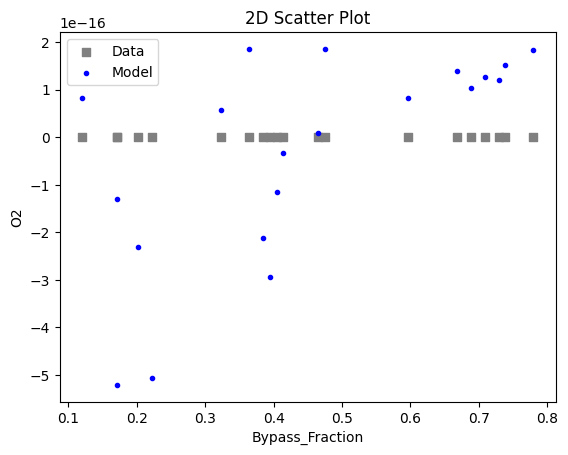

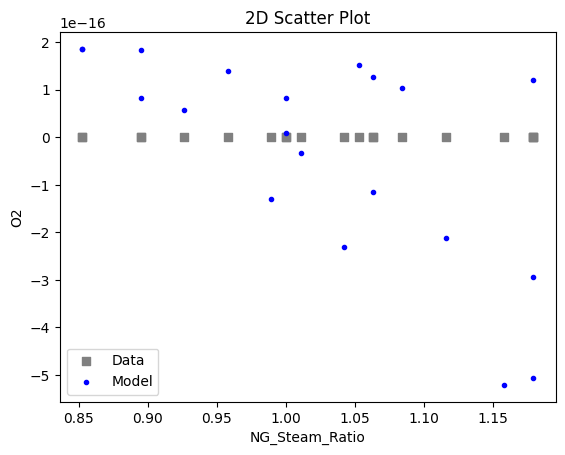

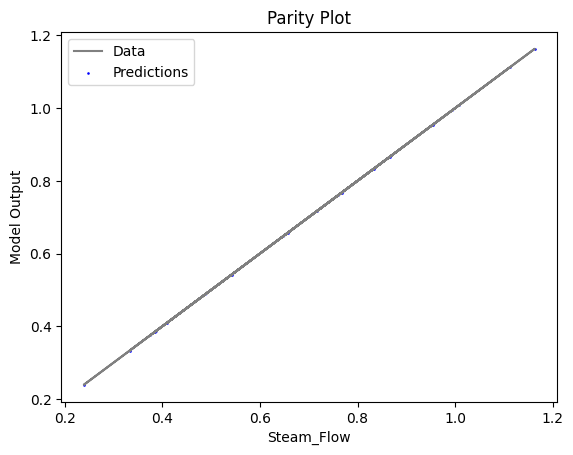

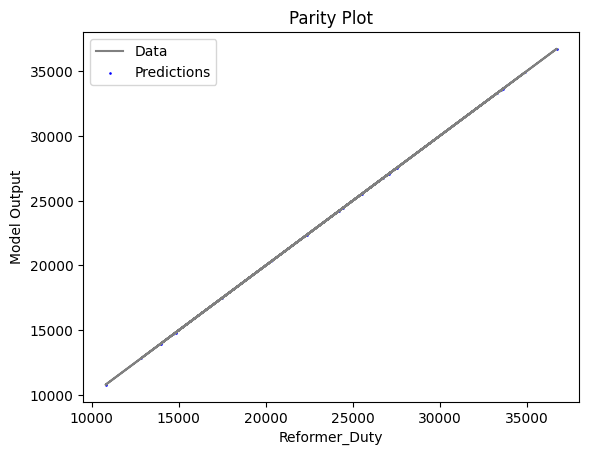

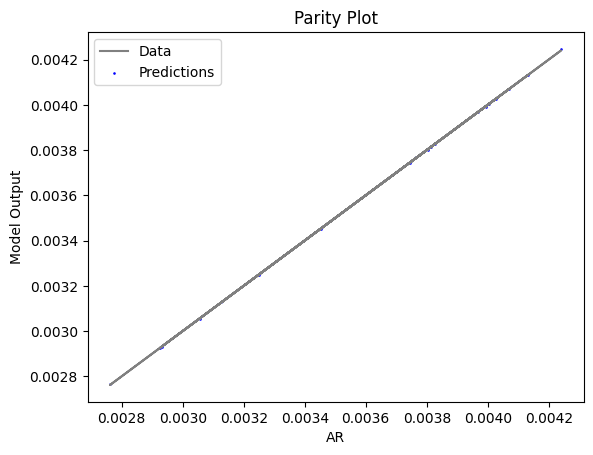

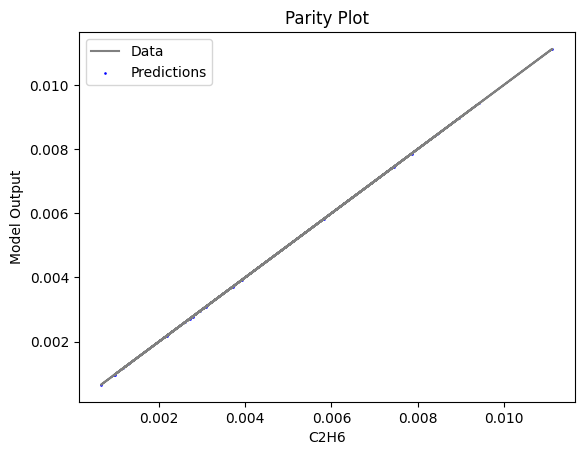

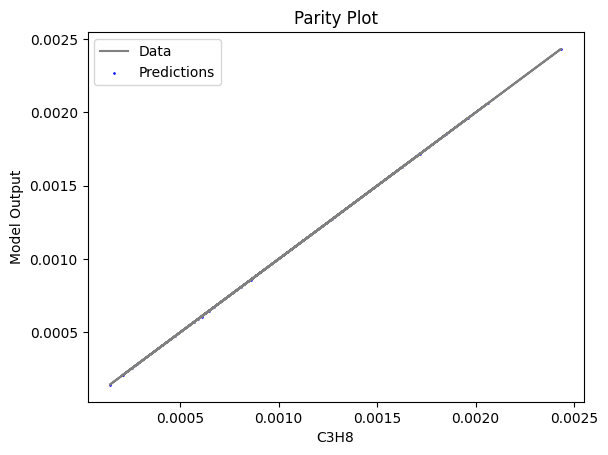

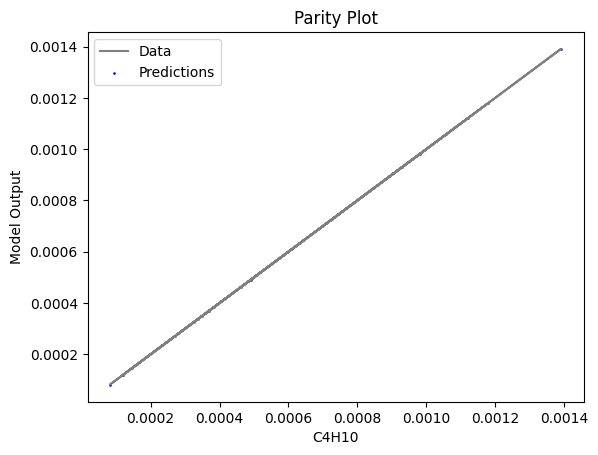

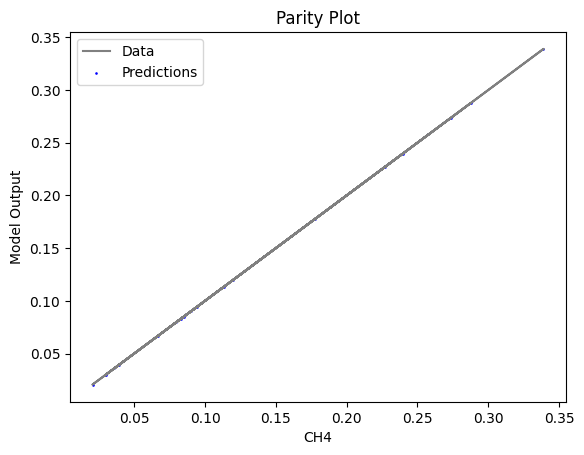

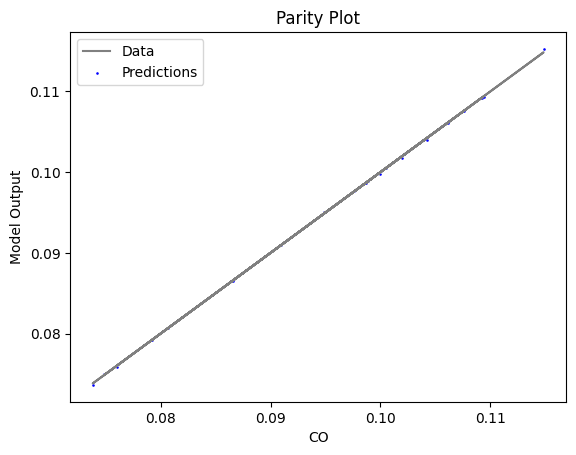

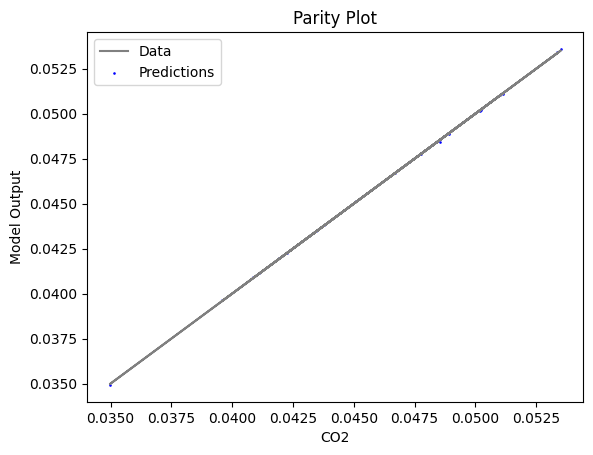

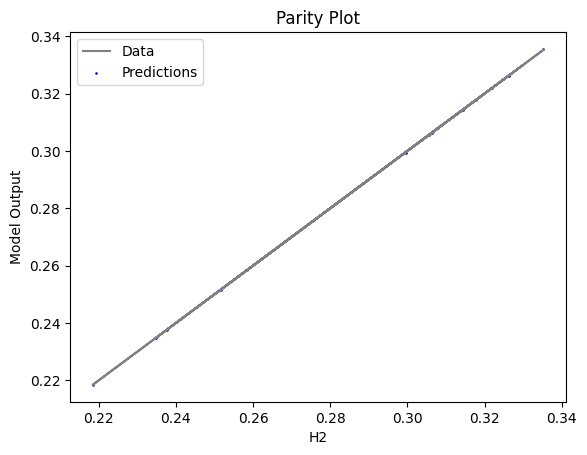

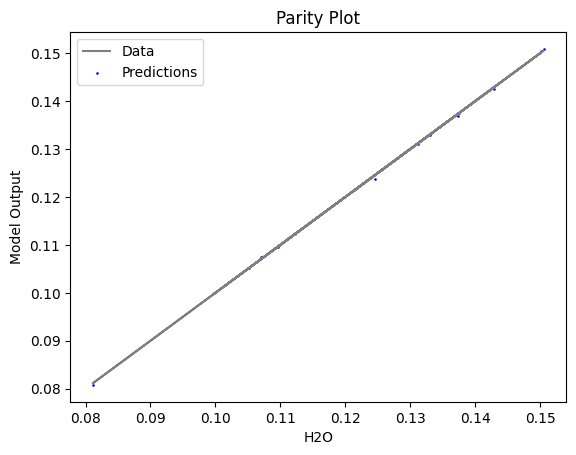

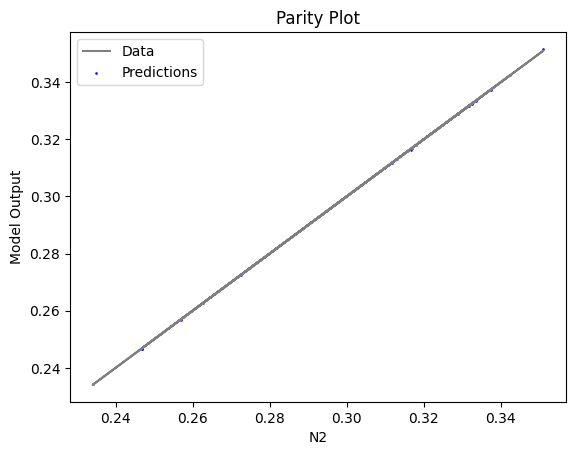

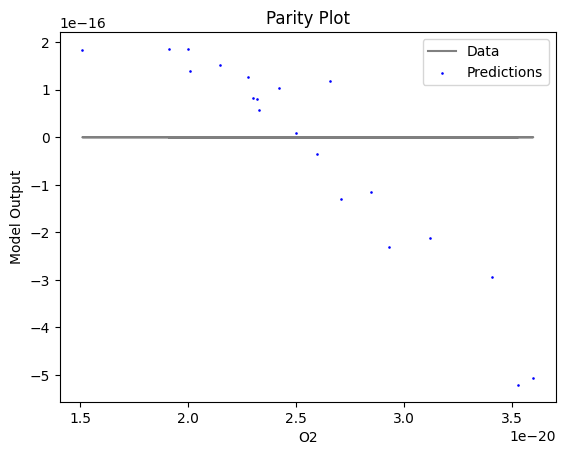

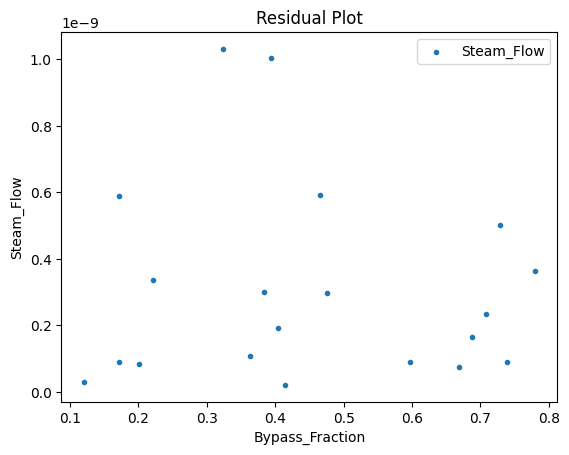

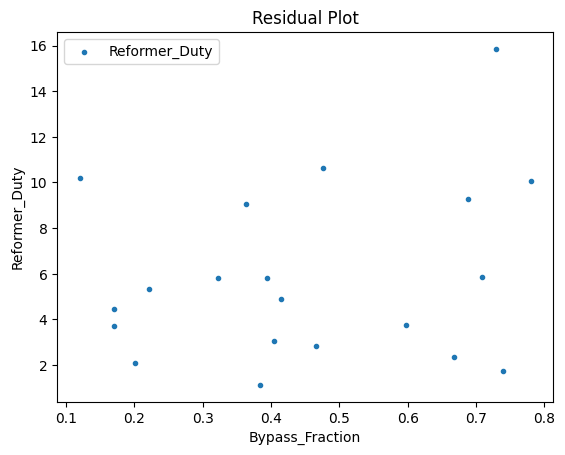

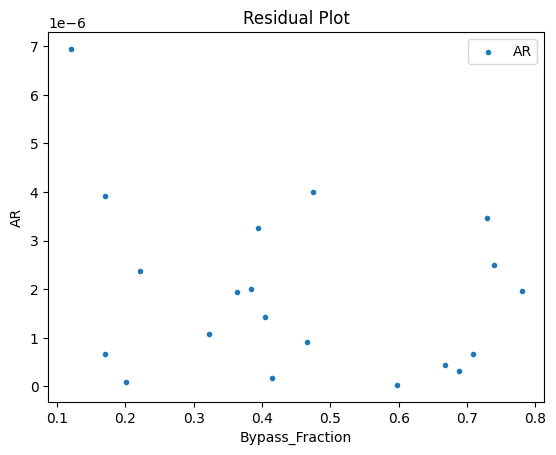

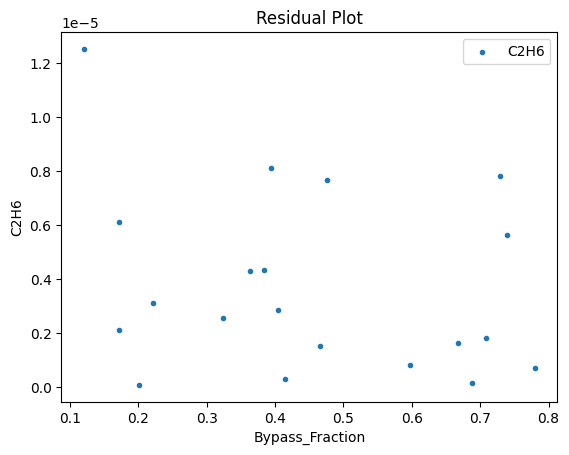

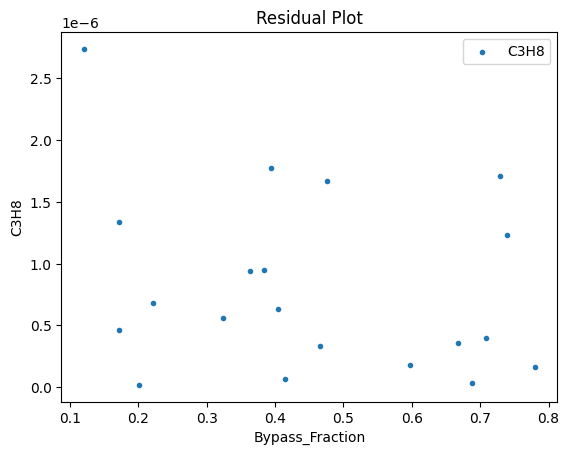

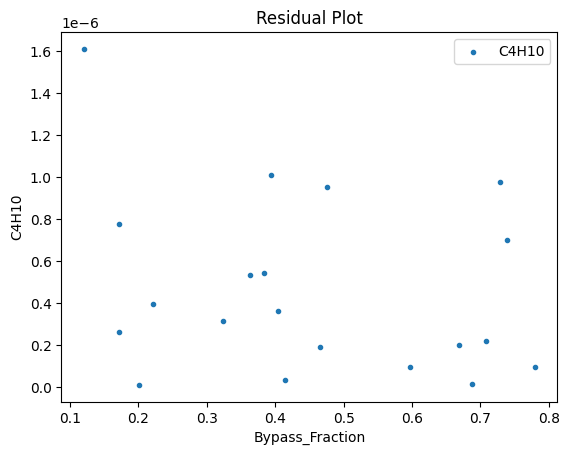

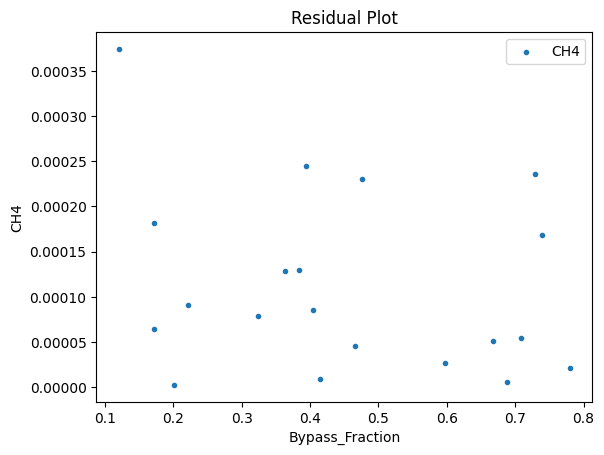

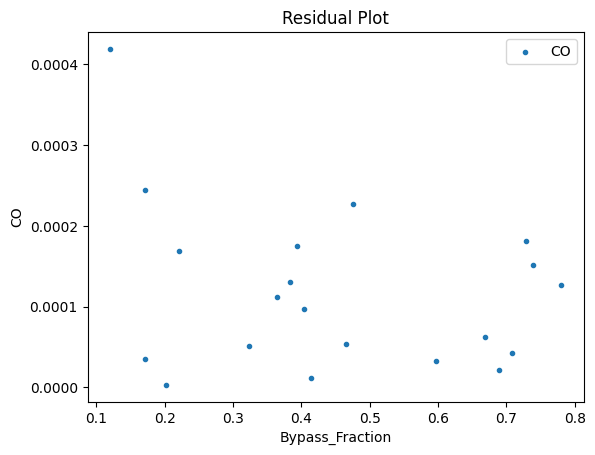

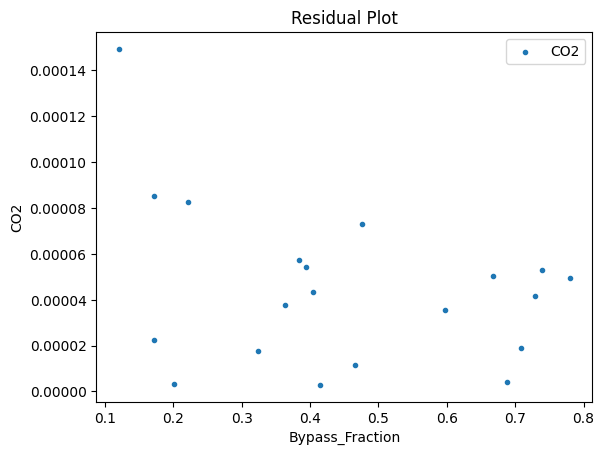

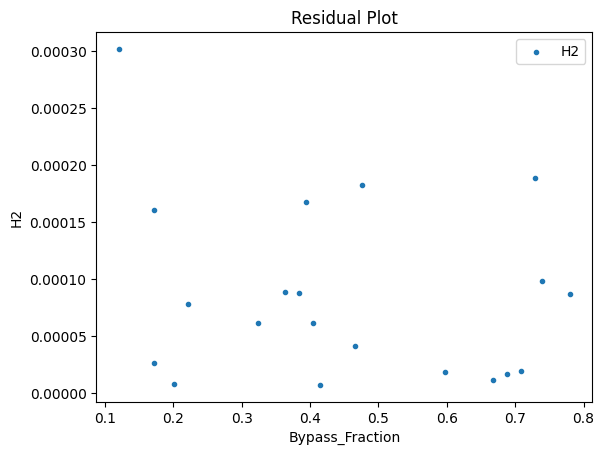

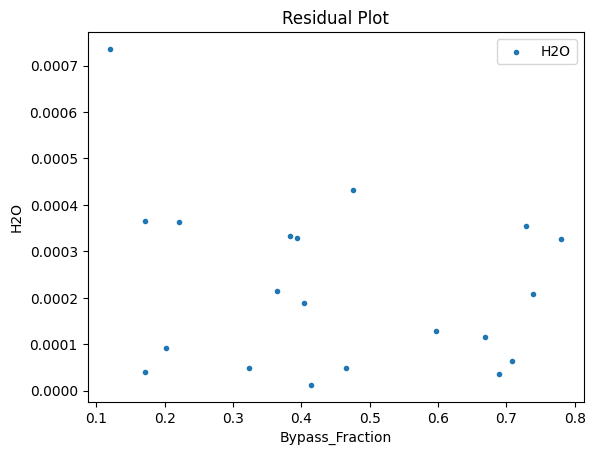

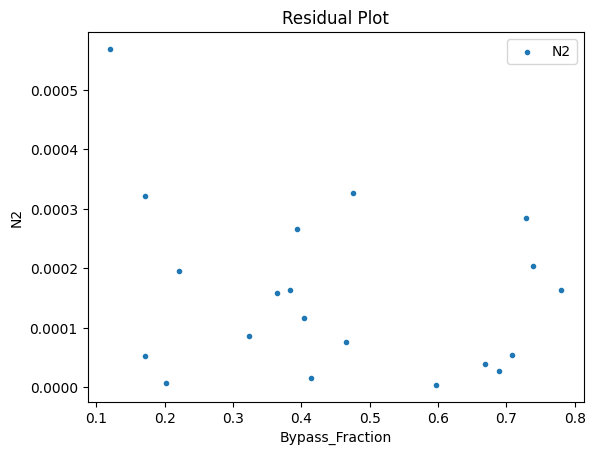

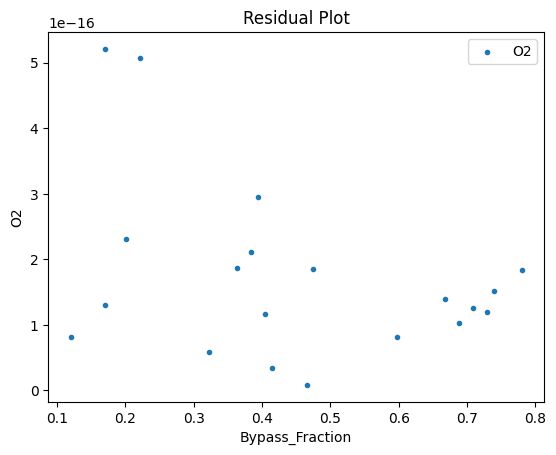

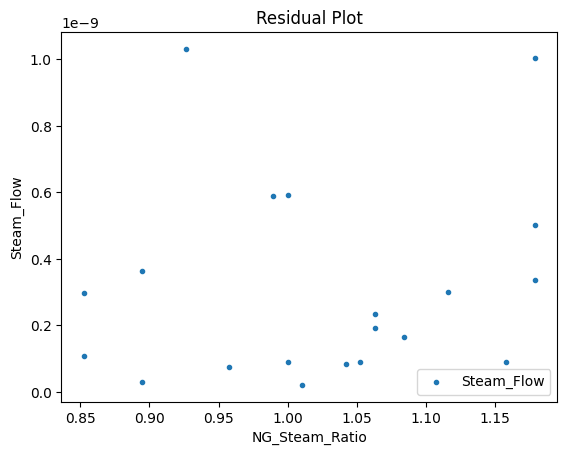

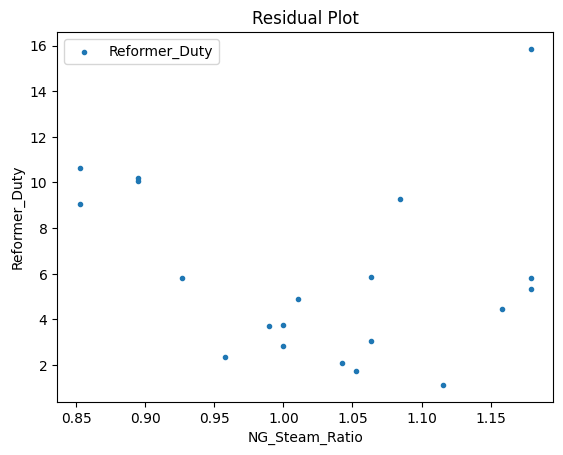

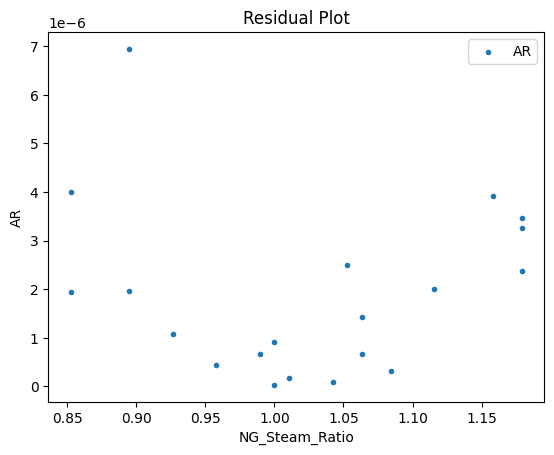

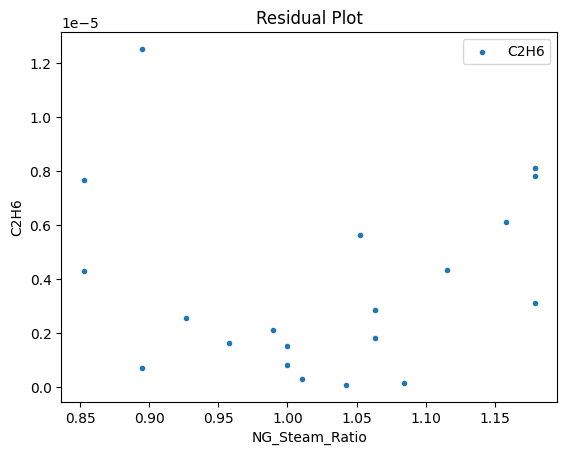

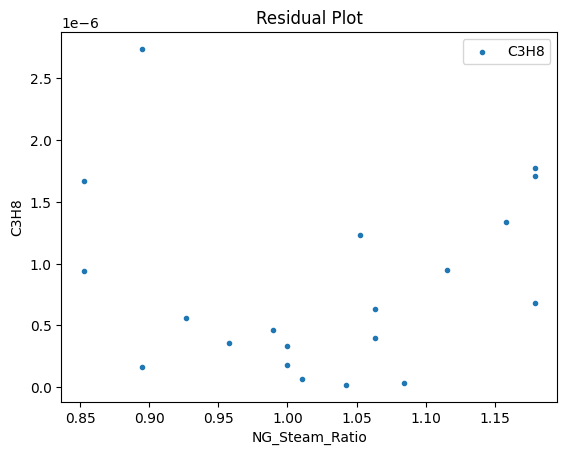

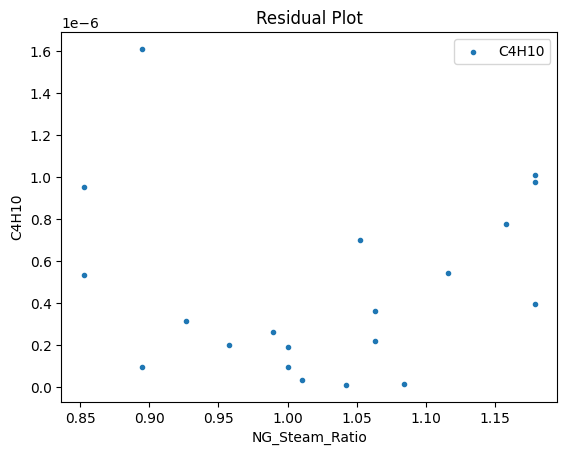

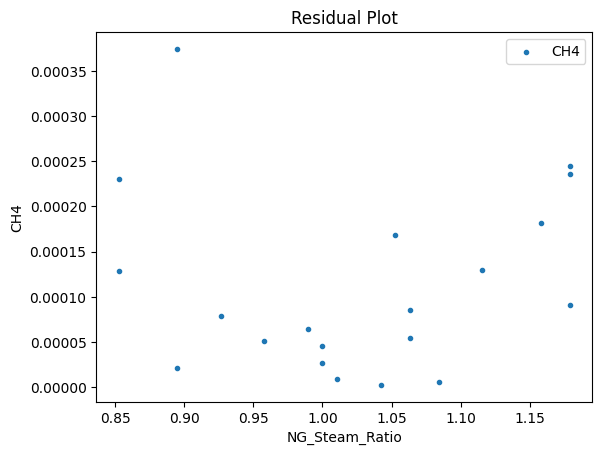

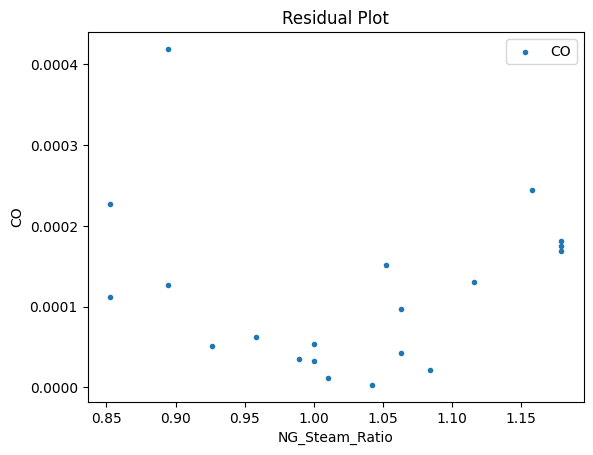

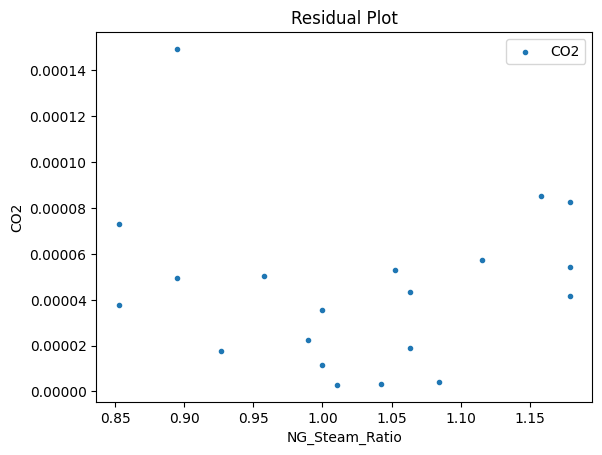

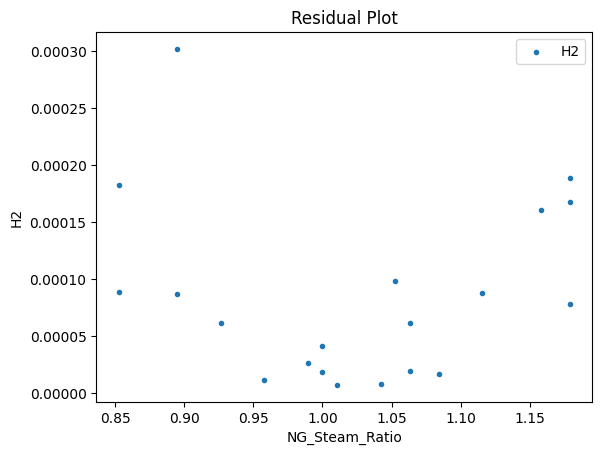

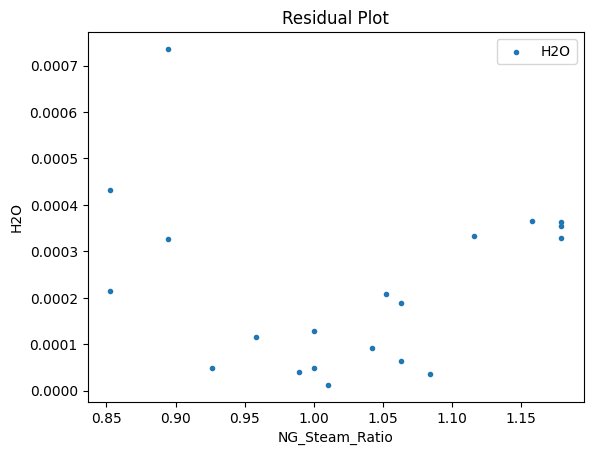

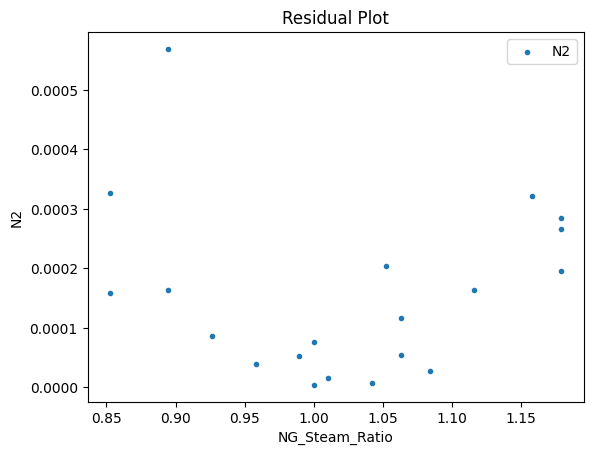

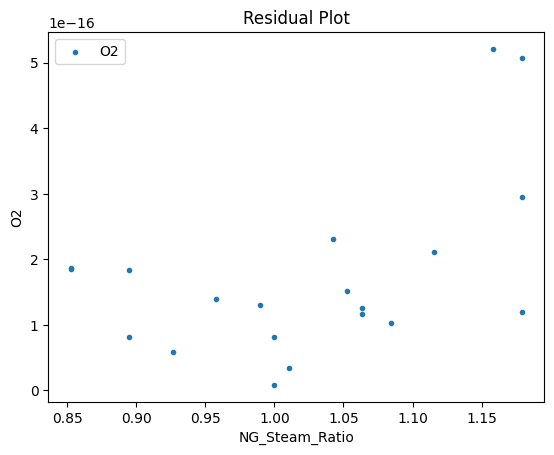

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [7]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(poly_surr, data_validation, filename="pysmo_poly_val_scatter2D.pdf")
surrogate_parity(poly_surr, data_validation, filename="pysmo_poly_val_parity.pdf")
surrogate_residual(poly_surr, data_validation, filename="pysmo_poly_val_residual.pdf")

# 4. IDAES Flowsheet Integration

## 4.1 Build and Run IDAES Flowsheet

Next, we will build an IDAES flowsheet and import the surrogate model object. Each output variable has a unique PySMO model expression, and the surrogate expressions may be added to the model via an indexed Constraint() component.

In [8]:
# create the IDAES model and flowsheet
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

# create flowsheet input variables
m.fs.bypass_frac = Var(
    initialize=0.80, bounds=[0.1, 0.8], doc="natural gas bypass fraction"
)
m.fs.ng_steam_ratio = Var(
    initialize=0.80, bounds=[0.8, 1.2], doc="natural gas to steam ratio"
)

# create flowsheet output variables
m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
m.fs.AR = Var(initialize=0, doc="AR fraction")
m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
m.fs.CO = Var(initialize=0, doc="CO fraction")
m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
m.fs.H2 = Var(initialize=0, doc="H2 fraction")
m.fs.H2O = Var(initialize=0, doc="H2O fraction")
m.fs.N2 = Var(initialize=0, doc="N2 fraction")
m.fs.O2 = Var(initialize=0, doc="O2 fraction")

# create input and output variable object lists for flowsheet
inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
outputs = [
    m.fs.steam_flowrate,
    m.fs.reformer_duty,
    m.fs.AR,
    m.fs.C2H6,
    m.fs.C4H10,
    m.fs.C3H8,
    m.fs.CH4,
    m.fs.CO,
    m.fs.CO2,
    m.fs.H2,
    m.fs.H2O,
    m.fs.N2,
    m.fs.O2,
]

# create the Pyomo/IDAES block that corresponds to the surrogate
# PySMO

# capture long output (not required to use surrogate API)
stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

surrogate = PysmoSurrogate.load_from_file("pysmo_poly_surrogate.json")
m.fs.surrogate = SurrogateBlock(concrete=True)
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)

# revert back to normal output capture - don't need to print PySMO load output
sys.stdout = oldstdout

# fix input values and solve flowsheet
m.fs.bypass_frac.fix(0.5)
m.fs.ng_steam_ratio.fix(1)

solver = SolverFactory("ipopt")
results = solver.solve(m, tee=True)

2025-03-17 17:38:21 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=poly


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Let's print some model results:

In [9]:
print("Steam flowrate = ", value(m.fs.steam_flowrate))
print("Reformer duty = ", value(m.fs.reformer_duty))
print("Mole Fraction Ar = ", value(m.fs.AR))
print("Mole Fraction C2H6 = ", value(m.fs.C2H6))
print("Mole Fraction C3H8 = ", value(m.fs.C3H8))
print("Mole Fraction C4H10 = ", value(m.fs.C4H10))
print("Mole Fraction CH4 = ", value(m.fs.CH4))
print("Mole Fraction CO = ", value(m.fs.CO))
print("Mole Fraction CO2 = ", value(m.fs.CO2))
print("Mole Fraction H2 = ", value(m.fs.H2))
print("Mole Fraction H2O = ", value(m.fs.H2O))
print("Mole Fraction N2 = ", value(m.fs.N2))
print("Mole Fraction O2 = ", value(m.fs.O2))

Steam flowrate =  0.6059308499318983
Reformer duty =  21072.561832018007
Mole Fraction Ar =  0.0036781507731262764
Mole Fraction C2H6 =  0.004188774062981508
Mole Fraction C3H8 =  0.0005235984950613115
Mole Fraction C4H10 =  0.0009162955373055101
Mole Fraction CH4 =  0.12790313523629443
Mole Fraction CO =  0.09689201209690862
Mole Fraction CO2 =  0.04604873637953224
Mole Fraction H2 =  0.2938240725288012
Mole Fraction H2O =  0.1196592238027376
Mole Fraction N2 =  0.3063429562761972
Mole Fraction O2 =  2.7755575615628914e-17


## 4.2 Optimizing the Autothermal Reformer
Extending this example, we will unfix the input variables and optimize hydrogen production. We will restrict nitrogen below 34 mol% of the product stream and leave all other variables unfixed.

Above, variable values are called in reference to actual objects names; however, as shown below this may be done much more compactly by calling the list objects we created earlier.

In [10]:
# unfix input values and add the objective/constraint to the model
m.fs.bypass_frac.unfix()
m.fs.ng_steam_ratio.unfix()
m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

# solve the model
tmr = TicTocTimer()
status = solver.solve(m, tee=True)
solve_time = tmr.toc("solve")

# print and check results
assert abs(value(m.fs.H2) - 0.33) <= 0.01
assert value(m.fs.N2 <= 0.4 + 1e-8)
print("Model status: ", status)
print("Solve time: ", solve_time)
for var in inputs:
    print(var.name, ": ", value(var))
for var in outputs:
    print(var.name, ": ", value(var))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[+   0.01] solve
Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 14
  Number of variables: 15
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.009012460708618164
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solve time:  0.012646308001421858
fs.bypass_frac :  0.10000006056376089
fs.ng_steam_ratio :  1.1232321922655462
fs.steam_flowrate :  1.2250817840789683
fs.reformer_duty :  39050.36780003482
fs.AR :  0.0041071693974047445
fs.C2H6 :  0.0005239281969648362
fs.C4H10 :  0.00011460579359301395
fs.C3H8 :  6.54784416506138e-05
fs.CH4 :  0.01634185961879082
fs.CO :  0.10487575125628976
fs.CO2 :  0.053535619369001815
fs.H2 :  0.3316590245876004
fs.H2O :  0.14885681247114485
fs.N2 :  0.3400000042903256
fs.O2 :  -5.134104614949322e-16
